## Compose

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

from sim.netrual import Component, NLT_reserve, NLT_components, NLT_accounts, NLT_REWARD  # noqa
from sim.data import get_batch_price, get_price, read_csv, format_ts as t
import pandas as pd
target = ['EOS', 'MANA', 'OMG', 'ARK', 'BNB', 'IOTA', 'ETH']
market_prices = get_batch_price(target)
m = market_prices.dropna()


In [2]:
# get_price('EOS')
m.describe()

,EOS,timestamp,MANA,OMG,ARK,BNB,IOTA,ETH
count,11022.000000,1.102200e+04,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000
mean,1.012053,1.504604e+12,0.065702,9.082596,3.162795,1.521508,0.459192,307.204804
std,0.334062,9.635453e+08,0.037275,1.075108,0.565987,0.709074,0.096970,37.771487
min,0.482895,1.502942e+12,0.013272,6.526780,1.481956,0.503544,0.301110,193.100000
25%,0.679737,1.503767e+12,0.017794,8.205073,2.866501,0.855845,0.408065,283.010000
50%,0.956240,1.504592e+12,0.078798,8.915736,3.124290,1.250860,0.448055,301.225000
75%,1.338159,1.505443e+12,0.097047,9.852690,3.413848,2.201847,0.497293,331.245000
max,1.583040,1.506267e+12,0.140380,13.793944,5.206336,2.956131,7.532500,394.320000


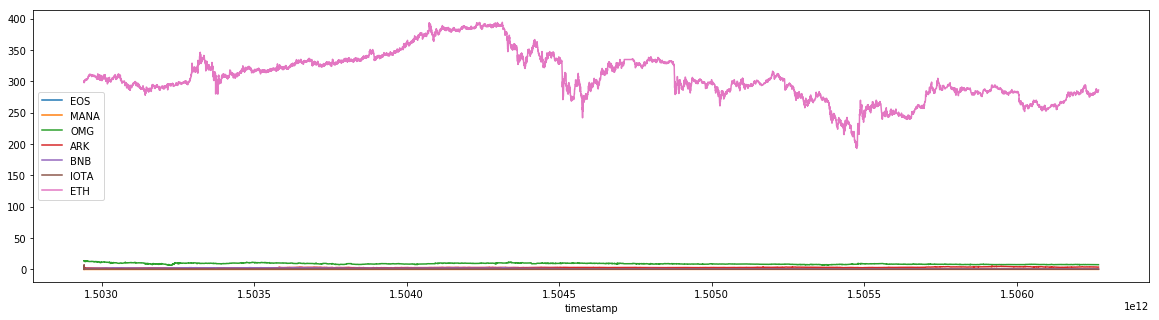

In [3]:
m.plot(x='timestamp', figsize=(20, 5))

In [4]:
tokens = [t for t in market_prices.columns if t != 'timestamp']
[Component(t) for t in tokens] 

[0.0 EOS => 0 NTL,
 0.0 MANA => 0 NTL,
 0.0 OMG => 0 NTL,
 0.0 ARK => 0 NTL,
 0.0 BNB => 0 NTL,
 0.0 IOTA => 0 NTL,
 0.0 ETH => 0 NTL]

### Warmup with rational auction on fixed price

In [5]:
def rational_warmup(timestamp, market_price, sender, inital_price):
    for c in NLT_components.values():
        res = c(timestamp).auction(sender, (float(inital_price) / float(market_price[c.token])) * NLT_REWARD)
        print(res)

In [6]:
def warmup(p=15):
    mp = m.T[0].drop('timestamp')
    start_time = t(m.T[0]['timestamp']) - Component.auction_window - 1
    sender = 'satoshi'
    inital_price = float(p)  # 15 USD
    rational_warmup(start_time, mp, sender, inital_price)
    [c(m.T[0].timestamp) for c in NLT_components.values()]

\begin{gather*}
\mathbb{P}_{auction_t} = \frac{\mathbb{P}_{target}}{\mathbb{P}_{market}} \times 1000 \\
t = Time_{current} - Time_{window}
\end{gather*}

### Price via highest components $P_h$.

\begin{gather*}
\frac{Highest(Price_{components}) \times min_{bid}(Highest(Price_{components}))}{1000} \ for\ each\ components
\end{gather*}

### Price via average auction bid $P_a$.

\begin{gather*}
\frac{\sum{component_{highest\ bid}\times component_{price}}}{NLT_{amount\ per\ round}}
\end{gather*}




In [7]:
from sim.utils import nlt_price as p_h, nlt_price_2 as p_a

In [8]:
from sim.utils import determin_auction_quantity, determin_redeem_quantity
from sim.utils import redeem_strategy as redeem, auction_strategy as auction

In [9]:
def simulator(a_t, r_t, s_r):
    ret = []
    for i, data in market_prices.iterrows():
        current = i
        print("==" * 10)
        print('round %s' % i)
        if i > s_r:
            plan_to_redeem = determin_redeem_quantity(data.drop('timestamp'), p_a, threshold=r_t)
            print('plan to redeem %s' % plan_to_redeem)
            redeem(plan_to_redeem, 'satoshi', data.timestamp)
        plan_to_auction = determin_auction_quantity(data.drop('timestamp'), p_a, threshold=a_t)
        auction(plan_to_auction, 'satoshi', data.timestamp)
        print('plan to auction %s' % plan_to_auction)

        ret.append(dict({
            'timestamp': data.timestamp,
            'price': p_a(data),
        }, **NLT_reserve))
    return pd.DataFrame(ret)


In [10]:
NLT_accounts['satoshi'] = 100000000000000
NLT_reserve = {t: 100000000000 for t, v in NLT_reserve.items()}
warmup(15)

True
True
True
True
True
True
True
EOS:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000001000}
MANA:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000002000}
OMG:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000003000}
ARK:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000004000}
BNB:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000005000}
IOTA:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000006000}
ETH:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000007000}


In [11]:
p_a(m.T[1]) # p_a

17.319626192963124

In [12]:
from sim.utils import get_worth_to_auction, get_worth_to_redeem, profit_rate
get_worth_to_auction(m.T[100].drop('timestamp'), p_a, threshold=0.000001)


{'BNB': {'delta': 879.57803222796429,
  'min_bid': 11212.159558816793,
  'price': 1.5795720000000002},
 'EOS': {'delta': 4192.1941198662444,
  'min_bid': 9475.43720630606,
  'price': 1.5194863200000004},
 'ETH': {'delta': 3162.1030434167205,
  'min_bid': 49.812373393550956,
  'price': 309.72},
 'MANA': {'delta': 2561.3373562100951,
  'min_bid': 928079.9881205761,
  'price': 0.0172707678},
 'OMG': {'delta': 4884.924254323063,
  'min_bid': 1095.2577900593658,
  'price': 12.513097100000001}}

In [13]:
(74747*1.5795720000000002)/1000

118.06826828400003

In [14]:
NLT_components

{'ARK': 10099.717881213852 ARK => 100000000007000 NTL,
 'BNB': 11212.159558816793 BNB => 100000000007000 NTL,
 'EOS': 9475.43720630606 EOS => 100000000007000 NTL,
 'ETH': 49.812373393550956 ETH => 100000000007000 NTL,
 'IOTA': 49815.68197668625 IOTA => 100000000007000 NTL,
 'MANA': 928079.9881205761 MANA => 100000000007000 NTL,
 'OMG': 1095.2577900593658 OMG => 100000000007000 NTL}

In [15]:
1 / profit_rate(m.T[100]['BNB'],p_a(m.T[100]),NLT_components['BNB'].min_bid)

1.0496644554475496

In [16]:
res = simulator(0.3, 0.1, 1)

round 0
plan to auction {}
round 1
plan to auction {'EOS': 11030.470864129387, 'OMG': 1319.669958427604, 'ARK': 11661.555890467298, 'BNB': 13167.183053599761, 'ETH': 58.11955098309773}
round 2
plan to redeem {'MANA': 1000}
MANA:: New cycle 2 <- 1
redeeming NLT_REWARD for MANA, reserve is 928079.9881205761
EOS:: New cycle 2 <- 1
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000007000}
OMG:: New cycle 2 <- 1
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000008000}
ARK:: New cycle 2 <- 1
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000009000}
BNB:: New cycle 2 <- 1
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000010000}
ETH:: New cycle 2 <- 1
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000011000}
plan to auction {'EOS': 40928.99403965821, 'MANA': 3443992.3323349515, 'OMG': 4782.803802914991, 'ARK': 43323.93602656133, 'BNB': 48591.91

plan to redeem {}
plan to auction {}
round 92
plan to redeem {}
plan to auction {}
round 93
plan to redeem {}
plan to auction {}
round 94
plan to redeem {}
plan to auction {}
round 95
plan to redeem {}
plan to auction {}
round 96
plan to redeem {}
plan to auction {}
round 97
plan to redeem {}
plan to auction {}
round 98
plan to redeem {}
plan to auction {}
round 99
plan to redeem {}
plan to auction {}
round 100
plan to redeem {}
plan to auction {}
round 101
plan to redeem {}
plan to auction {}
round 102
plan to redeem {}
plan to auction {}
round 103
plan to redeem {}
plan to auction {}
round 104
plan to redeem {}
EOS:: New cycle 53 <- 33
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000033000}
plan to auction {'EOS': 59195.85217611731}
round 105
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 148970.91649936815
plan to auction {}
round 106
plan to redeem {'ARK': 1000}
ARK:: New cycle 54 <- 4
redeeming NLT_REWARD for ARK, reserve is 6

plan to redeem {}
plan to auction {}
round 203
plan to redeem {}
plan to auction {}
round 204
plan to redeem {}
plan to auction {}
round 205
plan to redeem {}
plan to auction {}
round 206
plan to redeem {}
EOS:: New cycle 104 <- 53
plan to auction {'EOS': 59923.4020509602}
round 207
plan to redeem {}
OMG:: New cycle 104 <- 86
ARK:: New cycle 104 <- 94
plan to auction {'EOS': 59926.54062378846, 'OMG': 7724.702882710783, 'ARK': 44191.79000915244}
round 208
plan to redeem {}
EOS:: New cycle 105 <- 104
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000035000}
OMG:: New cycle 105 <- 104
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000036000}
ARK:: New cycle 105 <- 104
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000037000}
plan to auction {'EOS': 59485.81260223265, 'OMG': 7668.46220948364, 'ARK': 43974.125291815486}
round 209
plan to redeem {'EOS': 1000, 'OMG': 1000, 'ARK': 1000}
redeeming NLT_REWA

EOS:: New cycle 158 <- 157
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000039000}
MANA:: New cycle 158 <- 157
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000040000}
ARK:: New cycle 158 <- 157
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000041000}
IOTA:: New cycle 158 <- 156
ETH:: New cycle 158 <- 157
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000042000}
plan to auction {'EOS': 80879.08835608159, 'MANA': 7802437.283886283, 'OMG': 12075.85459372015, 'ARK': 64237.71126032395, 'IOTA': 196054.38721609392, 'ETH': 395.41786297288286}
round 315
plan to redeem {'EOS': 1000, 'MANA': 1000, 'OMG': 1000, 'ARK': 1000}
redeeming NLT_REWARD for EOS, reserve is 173448.87986301404
redeeming NLT_REWARD for MANA, reserve is 21906454.71178522
redeeming NLT_REWARD for OMG, reserve is 33326.001578566524
redeeming NLT_REWARD for ARK, reserve is 184533.11450383253
plan to auction

plan to auction {}
round 419
plan to redeem {}
plan to auction {}
round 420
plan to redeem {}
plan to auction {}
round 421
plan to redeem {}
plan to auction {}
round 422
plan to redeem {}
plan to auction {}
round 423
plan to redeem {}
plan to auction {}
round 424
plan to redeem {}
plan to auction {}
round 425
plan to redeem {}
plan to auction {}
round 426
plan to redeem {}
plan to auction {}
round 427
plan to redeem {}
plan to auction {}
round 428
plan to redeem {}
plan to auction {}
round 429
plan to redeem {}
plan to auction {}
round 430
plan to redeem {}
plan to auction {}
round 431
plan to redeem {}
plan to auction {}
round 432
plan to redeem {}
plan to auction {}
round 433
plan to redeem {}
plan to auction {}
round 434
plan to redeem {}
plan to auction {}
round 435
plan to redeem {}
plan to auction {}
round 436
plan to redeem {}
plan to auction {}
round 437
plan to redeem {}
plan to auction {}
round 438
plan to redeem {}
plan to auction {}
round 439
plan to redeem {}
plan to aucti

plan to auction {}
round 544
plan to redeem {}
plan to auction {}
round 545
plan to redeem {}
plan to auction {}
round 546
plan to redeem {}
plan to auction {}
round 547
plan to redeem {}
plan to auction {}
round 548
plan to redeem {}
plan to auction {}
round 549
plan to redeem {}
plan to auction {}
round 550
plan to redeem {}
plan to auction {}
round 551
plan to redeem {}
plan to auction {}
round 552
plan to redeem {}
plan to auction {}
round 553
plan to redeem {}
plan to auction {}
round 554
plan to redeem {}
plan to auction {}
round 555
plan to redeem {}
plan to auction {}
round 556
plan to redeem {}
plan to auction {}
round 557
plan to redeem {}
plan to auction {}
round 558
plan to redeem {}
plan to auction {}
round 559
plan to redeem {}
plan to auction {}
round 560
plan to redeem {}
plan to auction {}
round 561
plan to redeem {}
plan to auction {}
round 562
plan to redeem {}
plan to auction {}
round 563
plan to redeem {}
plan to auction {}
round 564
plan to redeem {}
plan to aucti

plan to redeem {}
plan to auction {}
round 664
plan to redeem {}
plan to auction {}
round 665
plan to redeem {}
plan to auction {}
round 666
plan to redeem {}
plan to auction {}
round 667
plan to redeem {}
plan to auction {}
round 668
plan to redeem {}
plan to auction {}
round 669
plan to redeem {}
plan to auction {}
round 670
plan to redeem {}
plan to auction {}
round 671
plan to redeem {}
plan to auction {}
round 672
plan to redeem {}
plan to auction {}
round 673
plan to redeem {}
plan to auction {}
round 674
plan to redeem {}
plan to auction {}
round 675
plan to redeem {}
plan to auction {}
round 676
plan to redeem {}
plan to auction {}
round 677
plan to redeem {}
plan to auction {}
round 678
plan to redeem {}
EOS:: New cycle 339 <- 329
plan to auction {'EOS': 99591.28515897352}
round 679
plan to redeem {}
EOS:: New cycle 340 <- 339
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000038000}
plan to auction {'EOS': 100444.30852332788}
round 680
plan to re

round 769
plan to redeem {}
plan to auction {}
round 770
plan to redeem {}
plan to auction {}
round 771
plan to redeem {}
plan to auction {}
round 772
plan to redeem {}
plan to auction {}
round 773
plan to redeem {}
plan to auction {}
round 774
plan to redeem {}
plan to auction {}
round 775
plan to redeem {}
plan to auction {}
round 776
plan to redeem {}
plan to auction {}
round 777
plan to redeem {}
plan to auction {}
round 778
plan to redeem {}
plan to auction {}
round 779
plan to redeem {}
plan to auction {}
round 780
plan to redeem {}
plan to auction {}
round 781
plan to redeem {}
plan to auction {}
round 782
plan to redeem {}
plan to auction {}
round 783
plan to redeem {}
plan to auction {}
round 784
plan to redeem {}
plan to auction {}
round 785
plan to redeem {}
plan to auction {}
round 786
plan to redeem {}
plan to auction {}
round 787
plan to redeem {}
plan to auction {}
round 788
plan to redeem {}
plan to auction {}
round 789
plan to redeem {}
plan to auction {}
round 790
pla

plan to auction {}
round 890
plan to redeem {}
plan to auction {}
round 891
plan to redeem {}
IOTA:: New cycle 446 <- 424
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000035000}
plan to auction {'IOTA': 266230.2715387703}
round 892
plan to redeem {'IOTA': 1000}
redeeming NLT_REWARD for IOTA, reserve is 585174.5943823544
plan to auction {}
round 893
plan to redeem {}
plan to auction {}
round 894
plan to redeem {}
plan to auction {}
round 895
plan to redeem {}
plan to auction {}
round 896
plan to redeem {}
plan to auction {}
round 897
plan to redeem {}
plan to auction {}
round 898
plan to redeem {}
plan to auction {}
round 899
plan to redeem {}
plan to auction {}
round 900
plan to redeem {}
OMG:: New cycle 450 <- 375
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000035000}
plan to auction {'OMG': 18578.862589026325}
round 901
plan to redeem {'OMG': 1000}
OMG:: New cycle 451 <- 450
Found last Winner
sent 1000 NTL to satoshi
Cu

plan to redeem {}
plan to auction {}
round 1017
plan to redeem {}
plan to auction {}
round 1018
plan to redeem {}
plan to auction {}
round 1019
plan to redeem {}
plan to auction {}
round 1020
plan to redeem {}
plan to auction {}
round 1021
plan to redeem {}
plan to auction {}
round 1022
plan to redeem {}
plan to auction {}
round 1023
plan to redeem {}
plan to auction {}
round 1024
plan to redeem {}
plan to auction {}
round 1025
plan to redeem {}
plan to auction {}
round 1026
plan to redeem {}
plan to auction {}
round 1027
plan to redeem {}
plan to auction {}
round 1028
plan to redeem {}
plan to auction {}
round 1029
plan to redeem {}
plan to auction {}
round 1030
plan to redeem {}
plan to auction {}
round 1031
plan to redeem {}
plan to auction {}
round 1032
plan to redeem {}
plan to auction {}
round 1033
plan to redeem {}
plan to auction {}
round 1034
plan to redeem {}
plan to auction {}
round 1035
plan to redeem {}
plan to auction {}
round 1036
plan to redeem {}
plan to auction {}
rou

plan to redeem {}
plan to auction {}
round 1241
plan to redeem {}
plan to auction {}
round 1242
plan to redeem {}
plan to auction {}
round 1243
plan to redeem {}
plan to auction {}
round 1244
plan to redeem {}
plan to auction {}
round 1245
plan to redeem {}
plan to auction {}
round 1246
plan to redeem {}
plan to auction {}
round 1247
plan to redeem {}
plan to auction {}
round 1248
plan to redeem {}
plan to auction {}
round 1249
plan to redeem {}
plan to auction {}
round 1250
plan to redeem {}
plan to auction {}
round 1251
plan to redeem {}
plan to auction {}
round 1252
plan to redeem {}
plan to auction {}
round 1253
plan to redeem {}
plan to auction {}
round 1254
plan to redeem {}
plan to auction {}
round 1255
plan to redeem {}
plan to auction {}
round 1256
plan to redeem {}
plan to auction {}
round 1257
plan to redeem {}
plan to auction {}
round 1258
plan to redeem {}
plan to auction {}
round 1259
plan to redeem {}
plan to auction {}
round 1260
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 1421
plan to redeem {}
plan to auction {}
round 1422
plan to redeem {}
plan to auction {}
round 1423
plan to redeem {}
plan to auction {}
round 1424
plan to redeem {}
plan to auction {}
round 1425
plan to redeem {}
plan to auction {}
round 1426
plan to redeem {}
plan to auction {}
round 1427
plan to redeem {}
plan to auction {}
round 1428
plan to redeem {}
plan to auction {}
round 1429
plan to redeem {}
plan to auction {}
round 1430
plan to redeem {}
plan to auction {}
round 1431
plan to redeem {}
plan to auction {}
round 1432
plan to redeem {}
plan to auction {}
round 1433
plan to redeem {}
plan to auction {}
round 1434
plan to redeem {}
plan to auction {}
round 1435
plan to redeem {}
plan to auction {}
round 1436
plan to redeem {}
plan to auction {}
round 1437
plan to redeem {}
plan to auction {}
round 1438
plan to redeem {}
plan to auction {}
round 1439
plan to redeem {}
plan to auction {}
round 1440
plan to redeem {}
plan to auction {}
round 1441
plan to re

plan to auction {}
round 1541
plan to redeem {}
plan to auction {}
round 1542
plan to redeem {}
plan to auction {}
round 1543
plan to redeem {}
plan to auction {}
round 1544
plan to redeem {}
plan to auction {}
round 1545
plan to redeem {}
plan to auction {}
round 1546
plan to redeem {}
plan to auction {}
round 1547
plan to redeem {}
plan to auction {}
round 1548
plan to redeem {}
plan to auction {}
round 1549
plan to redeem {}
plan to auction {}
round 1550
plan to redeem {}
plan to auction {}
round 1551
plan to redeem {}
plan to auction {}
round 1552
plan to redeem {}
plan to auction {}
round 1553
plan to redeem {}
plan to auction {}
round 1554
plan to redeem {}
plan to auction {}
round 1555
plan to redeem {}
plan to auction {}
round 1556
plan to redeem {}
plan to auction {}
round 1557
plan to redeem {}
plan to auction {}
round 1558
plan to redeem {}
plan to auction {}
round 1559
plan to redeem {}
plan to auction {}
round 1560
plan to redeem {}
plan to auction {}
round 1561
plan to re

plan to auction {}
round 1645
plan to redeem {}
plan to auction {}
round 1646
plan to redeem {}
plan to auction {}
round 1647
plan to redeem {}
MANA:: New cycle 823 <- 821
plan to auction {'MANA': 12947753.824881481}
round 1648
plan to redeem {}
plan to auction {'MANA': 13075169.334950201}
round 1649
plan to redeem {}
MANA:: New cycle 824 <- 823
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000034000}
plan to auction {'MANA': 13145349.249762045}
round 1650
plan to redeem {'MANA': 1000}
redeeming NLT_REWARD for MANA, reserve is 27263630.35740302
plan to auction {}
round 1651
plan to redeem {}
plan to auction {}
round 1652
plan to redeem {}
plan to auction {}
round 1653
plan to redeem {}
plan to auction {}
round 1654
plan to redeem {}
plan to auction {}
round 1655
plan to redeem {}
plan to auction {}
round 1656
plan to redeem {}
plan to auction {}
round 1657
plan to redeem {}
plan to auction {}
round 1658
plan to redeem {}
plan to auction {}
round 1659
plan

plan to redeem {}
plan to auction {}
round 1775
plan to redeem {}
plan to auction {}
round 1776
plan to redeem {}
plan to auction {}
round 1777
plan to redeem {}
plan to auction {}
round 1778
plan to redeem {}
plan to auction {}
round 1779
plan to redeem {}
ARK:: New cycle 889 <- 500
plan to auction {'ARK': 84150.01434654657}
round 1780
plan to redeem {}
plan to auction {'ARK': 84322.1557648735}
round 1781
plan to redeem {}
ARK:: New cycle 890 <- 889
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000034000}
plan to auction {'ARK': 84167.54399353993}
round 1782
plan to redeem {'ARK': 1000}
redeeming NLT_REWARD for ARK, reserve is 205500.76080458984
plan to auction {'ARK': 84501.46646799409}
round 1783
plan to redeem {}
ARK:: New cycle 891 <- 890
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000034000}
plan to auction {'ARK': 84462.9830895755}
round 1784
plan to redeem {'ARK': 1000}
redeeming NLT_REWARD for ARK, reserve is 2056

round 1997
plan to redeem {}
plan to auction {}
round 1998
plan to redeem {}
plan to auction {}
round 1999
plan to redeem {}
plan to auction {}
round 2000
plan to redeem {}
plan to auction {}
round 2001
plan to redeem {}
plan to auction {}
round 2002
plan to redeem {}
plan to auction {}
round 2003
plan to redeem {}
plan to auction {}
round 2004
plan to redeem {}
plan to auction {}
round 2005
plan to redeem {}
plan to auction {}
round 2006
plan to redeem {}
plan to auction {}
round 2007
plan to redeem {}
plan to auction {}
round 2008
plan to redeem {}
plan to auction {}
round 2009
plan to redeem {}
plan to auction {}
round 2010
plan to redeem {}
plan to auction {}
round 2011
plan to redeem {}
plan to auction {}
round 2012
plan to redeem {}
plan to auction {}
round 2013
plan to redeem {}
plan to auction {}
round 2014
plan to redeem {}
plan to auction {}
round 2015
plan to redeem {}
plan to auction {}
round 2016
plan to redeem {}
plan to auction {}
round 2017
plan to redeem {}
plan to auc

round 2117
plan to redeem {}
plan to auction {}
round 2118
plan to redeem {}
plan to auction {}
round 2119
plan to redeem {}
plan to auction {}
round 2120
plan to redeem {}
plan to auction {}
round 2121
plan to redeem {}
plan to auction {}
round 2122
plan to redeem {}
plan to auction {}
round 2123
plan to redeem {}
plan to auction {}
round 2124
plan to redeem {}
plan to auction {}
round 2125
plan to redeem {}
plan to auction {}
round 2126
plan to redeem {}
plan to auction {}
round 2127
plan to redeem {}
BNB:: New cycle 1062 <- 505
IOTA:: New cycle 1062 <- 923
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000035000}
plan to auction {'BNB': 87163.29874889913, 'IOTA': 418408.2782565889}
round 2128
plan to redeem {'IOTA': 1000}
IOTA:: New cycle 1063 <- 1062
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000036000}
redeeming NLT_REWARD for IOTA, reserve is 1480294.3966118088
BNB:: New cycle 1063 <- 1062
Found last Winner
sent 1000

plan to redeem {}
plan to auction {}
round 2247
plan to redeem {}
plan to auction {}
round 2248
plan to redeem {}
plan to auction {}
round 2249
plan to redeem {}
plan to auction {}
round 2250
plan to redeem {}
plan to auction {}
round 2251
plan to redeem {}
plan to auction {}
round 2252
plan to redeem {}
plan to auction {}
round 2253
plan to redeem {}
plan to auction {}
round 2254
plan to redeem {}
plan to auction {}
round 2255
plan to redeem {}
plan to auction {}
round 2256
plan to redeem {}
plan to auction {}
round 2257
plan to redeem {}
plan to auction {}
round 2258
plan to redeem {}
plan to auction {}
round 2259
plan to redeem {}
plan to auction {}
round 2260
plan to redeem {}
plan to auction {}
round 2261
plan to redeem {}
plan to auction {}
round 2262
plan to redeem {}
plan to auction {}
round 2263
plan to redeem {}
plan to auction {}
round 2264
plan to redeem {}
plan to auction {}
round 2265
plan to redeem {}
plan to auction {}
round 2266
plan to redeem {}
plan to auction {}
rou

plan to redeem {}
plan to auction {}
round 2369
plan to redeem {}
plan to auction {}
round 2370
plan to redeem {}
plan to auction {}
round 2371
plan to redeem {}
plan to auction {}
round 2372
plan to redeem {}
plan to auction {}
round 2373
plan to redeem {}
plan to auction {}
round 2374
plan to redeem {}
plan to auction {}
round 2375
plan to redeem {}
plan to auction {}
round 2376
plan to redeem {}
plan to auction {}
round 2377
plan to redeem {}
plan to auction {}
round 2378
plan to redeem {}
OMG:: New cycle 1188 <- 1181
plan to auction {'OMG': 26176.62412162239}
round 2379
plan to redeem {}
plan to auction {'OMG': 26134.635597338875}
round 2380
plan to redeem {}
EOS:: New cycle 1189 <- 1181
MANA:: New cycle 1189 <- 1181
OMG:: New cycle 1189 <- 1188
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000036000}
plan to auction {'EOS': 188812.6102069907, 'MANA': 16430535.612295203, 'OMG': 26343.262803078374}
round 2381
plan to redeem {'OMG': 1000}
redeeming NLT_

plan to redeem {}
plan to auction {}
round 2495
plan to redeem {}
plan to auction {}
round 2496
plan to redeem {}
plan to auction {}
round 2497
plan to redeem {}
plan to auction {}
round 2498
plan to redeem {}
plan to auction {}
round 2499
plan to redeem {}
plan to auction {}
round 2500
plan to redeem {}
plan to auction {}
round 2501
plan to redeem {}
plan to auction {}
round 2502
plan to redeem {}
plan to auction {}
round 2503
plan to redeem {}
plan to auction {}
round 2504
plan to redeem {}
plan to auction {}
round 2505
plan to redeem {}
plan to auction {}
round 2506
plan to redeem {}
plan to auction {}
round 2507
plan to redeem {}
plan to auction {}
round 2508
plan to redeem {}
plan to auction {}
round 2509
plan to redeem {}
plan to auction {}
round 2510
plan to redeem {}
plan to auction {}
round 2511
plan to redeem {}
plan to auction {}
round 2512
plan to redeem {}
plan to auction {}
round 2513
plan to redeem {}
plan to auction {}
round 2514
plan to redeem {}
plan to auction {}
rou

plan to redeem {}
plan to auction {}
round 2621
plan to redeem {}
plan to auction {}
round 2622
plan to redeem {}
plan to auction {}
round 2623
plan to redeem {}
plan to auction {}
round 2624
plan to redeem {}
plan to auction {}
round 2625
plan to redeem {}
plan to auction {}
round 2626
plan to redeem {}
plan to auction {}
round 2627
plan to redeem {}
plan to auction {}
round 2628
plan to redeem {}
plan to auction {}
round 2629
plan to redeem {}
plan to auction {}
round 2630
plan to redeem {}
plan to auction {}
round 2631
plan to redeem {}
plan to auction {}
round 2632
plan to redeem {}
plan to auction {}
round 2633
plan to redeem {}
plan to auction {}
round 2634
plan to redeem {}
plan to auction {}
round 2635
plan to redeem {}
plan to auction {}
round 2636
plan to redeem {}
plan to auction {}
round 2637
plan to redeem {}
plan to auction {}
round 2638
plan to redeem {}
plan to auction {}
round 2639
plan to redeem {}
plan to auction {}
round 2640
plan to redeem {}
plan to auction {}
rou

plan to redeem {'OMG': 1000}
redeeming NLT_REWARD for OMG, reserve is 74724.54725316213
plan to auction {'OMG': 30101.04763112813}
round 2745
plan to redeem {}
OMG:: New cycle 1371 <- 1370
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000037000}
plan to auction {'OMG': 30400.84158607793}
round 2746
plan to redeem {'OMG': 1000}
redeeming NLT_REWARD for OMG, reserve is 74747.00698232497
plan to auction {}
round 2747
plan to redeem {}
plan to auction {}
round 2748
plan to redeem {}
plan to auction {}
round 2749
plan to redeem {}
plan to auction {}
round 2750
plan to redeem {}
plan to auction {}
round 2751
plan to redeem {}
plan to auction {}
round 2752
plan to redeem {}
plan to auction {}
round 2753
plan to redeem {}
plan to auction {}
round 2754
plan to redeem {}
plan to auction {}
round 2755
plan to redeem {}
plan to auction {}
round 2756
plan to redeem {}
plan to auction {}
round 2757
plan to redeem {}
plan to auction {}
round 2758
plan to redeem {}
plan 

plan to redeem {}
plan to auction {}
round 2864
plan to redeem {}
plan to auction {}
round 2865
plan to redeem {}
plan to auction {}
round 2866
plan to redeem {}
plan to auction {}
round 2867
plan to redeem {}
plan to auction {}
round 2868
plan to redeem {}
plan to auction {}
round 2869
plan to redeem {}
plan to auction {}
round 2870
plan to redeem {}
plan to auction {}
round 2871
plan to redeem {}
plan to auction {}
round 2872
plan to redeem {}
BNB:: New cycle 1434 <- 1403
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000037000}
plan to auction {'BNB': 136795.3059080942}
round 2873
plan to redeem {'BNB': 1000}
BNB:: New cycle 1435 <- 1434
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000038000}
redeeming NLT_REWARD for BNB, reserve is 486758.66981819377
plan to auction {}
round 2874
plan to redeem {'BNB': 2000}
redeeming NLT_REWARD for BNB, reserve is 349963.3639100996
redeeming NLT_REWARD for BNB, reserve is 229740.4735872

round 2961
plan to redeem {}
EOS:: New cycle 1479 <- 1189
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000037000}
plan to auction {'EOS': 200938.6900252287}
round 2962
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 395559.5579764617
plan to auction {}
round 2963
plan to redeem {}
plan to auction {}
round 2964
plan to redeem {}
plan to auction {}
round 2965
plan to redeem {}
plan to auction {}
round 2966
plan to redeem {}
plan to auction {}
round 2967
plan to redeem {}
plan to auction {}
round 2968
plan to redeem {}
plan to auction {}
round 2969
plan to redeem {}
plan to auction {}
round 2970
plan to redeem {}
ARK:: New cycle 1483 <- 1368
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000037000}
plan to auction {'ARK': 96648.88599420877}
round 2971
plan to redeem {'ARK': 1000}
ARK:: New cycle 1484 <- 1483
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000038000}
redeeming N

plan to redeem {}
plan to auction {}
round 3094
plan to redeem {}
plan to auction {}
round 3095
plan to redeem {}
plan to auction {}
round 3096
plan to redeem {}
plan to auction {}
round 3097
plan to redeem {}
plan to auction {}
round 3098
plan to redeem {}
plan to auction {}
round 3099
plan to redeem {}
plan to auction {}
round 3100
plan to redeem {}
plan to auction {}
round 3101
plan to redeem {}
plan to auction {}
round 3102
plan to redeem {}
plan to auction {}
round 3103
plan to redeem {}
plan to auction {}
round 3104
plan to redeem {}
plan to auction {}
round 3105
plan to redeem {}
plan to auction {}
round 3106
plan to redeem {}
plan to auction {}
round 3107
plan to redeem {}
plan to auction {}
round 3108
plan to redeem {}
plan to auction {}
round 3109
plan to redeem {}
plan to auction {}
round 3110
plan to redeem {}
plan to auction {}
round 3111
plan to redeem {}
plan to auction {}
round 3112
plan to redeem {}
plan to auction {}
round 3113
plan to redeem {}
plan to auction {}
rou

plan to redeem {}
plan to auction {}
round 3233
plan to redeem {}
plan to auction {}
round 3234
plan to redeem {}
plan to auction {}
round 3235
plan to redeem {}
plan to auction {}
round 3236
plan to redeem {}
plan to auction {}
round 3237
plan to redeem {}
plan to auction {}
round 3238
plan to redeem {}
plan to auction {}
round 3239
plan to redeem {}
plan to auction {}
round 3240
plan to redeem {}
plan to auction {}
round 3241
plan to redeem {}
plan to auction {}
round 3242
plan to redeem {}
plan to auction {}
round 3243
plan to redeem {}
plan to auction {}
round 3244
plan to redeem {}
plan to auction {}
round 3245
plan to redeem {}
plan to auction {}
round 3246
plan to redeem {}
plan to auction {}
round 3247
plan to redeem {}
plan to auction {}
round 3248
plan to redeem {}
BNB:: New cycle 1622 <- 1461
IOTA:: New cycle 1622 <- 1581
plan to auction {'BNB': 151243.4471190601, 'IOTA': 637407.9559101366}
round 3249
plan to redeem {}
EOS:: New cycle 1622 <- 1581
Found last Winner
sent 1000

round 3439
plan to redeem {}
plan to auction {}
round 3440
plan to redeem {}
plan to auction {}
round 3441
plan to redeem {}
plan to auction {}
round 3442
plan to redeem {}
plan to auction {}
round 3443
plan to redeem {}
plan to auction {}
round 3444
plan to redeem {}
plan to auction {}
round 3445
plan to redeem {}
plan to auction {}
round 3446
plan to redeem {}
plan to auction {}
round 3447
plan to redeem {}
plan to auction {}
round 3448
plan to redeem {}
plan to auction {}
round 3449
plan to redeem {}
plan to auction {}
round 3450
plan to redeem {}
plan to auction {}
round 3451
plan to redeem {}
plan to auction {}
round 3452
plan to redeem {}
plan to auction {}
round 3453
plan to redeem {}
plan to auction {}
round 3454
plan to redeem {}
plan to auction {}
round 3455
plan to redeem {}
plan to auction {}
round 3456
plan to redeem {}
plan to auction {}
round 3457
plan to redeem {}
plan to auction {}
round 3458
plan to redeem {}
plan to auction {}
round 3459
plan to redeem {}
plan to auc

plan to redeem {}
OMG:: New cycle 1779 <- 1762
plan to auction {'OMG': 44074.75757651583}
round 3564
plan to redeem {}
plan to auction {'OMG': 43610.18724753067}
round 3565
plan to redeem {}
OMG:: New cycle 1780 <- 1779
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000041000}
BNB:: New cycle 1780 <- 1762
ETH:: New cycle 1780 <- 1762
plan to auction {'OMG': 43593.386847193746, 'BNB': 184961.58920170495, 'ETH': 1023.3897995405599}
round 3566
plan to redeem {'OMG': 1000}
redeeming NLT_REWARD for OMG, reserve is 88720.71692771265
plan to auction {'OMG': 43540.79955494411, 'BNB': 185291.51230516855, 'ETH': 1027.911026591303}
round 3567
plan to redeem {}
OMG:: New cycle 1781 <- 1780
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000041000}
BNB:: New cycle 1781 <- 1780
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000042000}
ETH:: New cycle 1781 <- 1780
Found last Winner
sent 1000 NTL to satoshi
Curren

EOS:: New cycle 1831 <- 1830
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000046000}
OMG:: New cycle 1831 <- 1830
ARK:: New cycle 1831 <- 1830
BNB:: New cycle 1831 <- 1830
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000047000}
IOTA:: New cycle 1831 <- 1829
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000048000}
ETH:: New cycle 1831 <- 1830
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000049000}
plan to auction {'EOS': 507834.55065805465, 'OMG': 78172.99288552959, 'ARK': 228504.80369798178, 'BNB': 325564.03451176203, 'IOTA': 1477377.1716541215, 'ETH': 1809.7595794539016}
round 3668
plan to redeem {'EOS': 1000, 'BNB': 1000, 'IOTA': 1000, 'ETH': 1000}
redeeming NLT_REWARD for EOS, reserve is 1384054.7767781536
redeeming NLT_REWARD for BNB, reserve is 792571.4327953793
redeeming NLT_REWARD for IOTA, reserve is 4163799.421373358
redeeming NLT_REWARD for ETH, reser

round 3769
plan to redeem {}
EOS:: New cycle 1882 <- 1881
plan to auction {'EOS': 736877.0391921357}
round 3770
plan to redeem {}
plan to auction {'EOS': 743875.5843258232}
round 3771
plan to redeem {}
EOS:: New cycle 1883 <- 1882
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000048000}
plan to auction {'EOS': 741359.7528760073}
round 3772
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 1627813.0628180748
plan to auction {'EOS': 742932.7136925722}
round 3773
plan to redeem {}
EOS:: New cycle 1884 <- 1883
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000048000}
plan to auction {'EOS': 745702.5224630713}
round 3774
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 1626870.1921848238
plan to auction {}
round 3775
plan to redeem {}
plan to auction {}
round 3776
plan to redeem {}
plan to auction {}
round 3777
plan to redeem {}
plan to auction {}
round 3778
plan to redeem {}
plan to auctio

plan to redeem {'BNB': 2000, 'IOTA': 2000, 'ETH': 1000}
redeeming NLT_REWARD for BNB, reserve is 1517477.8868545233
redeeming NLT_REWARD for BNB, reserve is 992209.8472255174
redeeming NLT_REWARD for IOTA, reserve is 8009375.121883467
redeeming NLT_REWARD for IOTA, reserve is 5285529.221022196
redeeming NLT_REWARD for ETH, reserve is 6590.08654668316
EOS:: New cycle 1945 <- 1944
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000049000}
OMG:: New cycle 1945 <- 1920
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000050000}
ARK:: New cycle 1945 <- 1921
plan to auction {'EOS': 942785.9307866396, 'OMG': 115762.0492219298, 'ARK': 387987.0695904681, 'BNB': 545155.6030057913, 'IOTA': 2790675.810247301}
round 3897
plan to redeem {'EOS': 1000, 'OMG': 1000}
EOS:: New cycle 1946 <- 1945
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000051000}
redeeming NLT_REWARD for EOS, reserve is 3688524.1346974233
OMG:: 

plan to auction {}
round 4010
plan to redeem {}
plan to auction {}
round 4011
plan to redeem {}
plan to auction {}
round 4012
plan to redeem {}
plan to auction {}
round 4013
plan to redeem {}
plan to auction {}
round 4014
plan to redeem {}
plan to auction {}
round 4015
plan to redeem {}
plan to auction {}
round 4016
plan to redeem {}
plan to auction {}
round 4017
plan to redeem {}
plan to auction {}
round 4018
plan to redeem {}
plan to auction {}
round 4019
plan to redeem {}
plan to auction {}
round 4020
plan to redeem {}
plan to auction {}
round 4021
plan to redeem {}
plan to auction {}
round 4022
plan to redeem {}
plan to auction {}
round 4023
plan to redeem {}
plan to auction {}
round 4024
plan to redeem {}
plan to auction {}
round 4025
plan to redeem {}
plan to auction {}
round 4026
plan to redeem {}
plan to auction {}
round 4027
plan to redeem {}
plan to auction {}
round 4028
plan to redeem {}
plan to auction {}
round 4029
plan to redeem {}
plan to auction {}
round 4030
plan to re

plan to redeem {}
plan to auction {}
round 4129
plan to redeem {}
plan to auction {}
round 4130
plan to redeem {}
plan to auction {}
round 4131
plan to redeem {}
plan to auction {}
round 4132
plan to redeem {}
plan to auction {}
round 4133
plan to redeem {}
plan to auction {}
round 4134
plan to redeem {}
plan to auction {}
round 4135
plan to redeem {}
plan to auction {}
round 4136
plan to redeem {}
plan to auction {}
round 4137
plan to redeem {}
plan to auction {}
round 4138
plan to redeem {}
plan to auction {}
round 4139
plan to redeem {}
plan to auction {}
round 4140
plan to redeem {}
plan to auction {}
round 4141
plan to redeem {}
plan to auction {}
round 4142
plan to redeem {}
plan to auction {}
round 4143
plan to redeem {}
plan to auction {}
round 4144
plan to redeem {}
plan to auction {}
round 4145
plan to redeem {}
plan to auction {}
round 4146
plan to redeem {}
plan to auction {}
round 4147
plan to redeem {}
plan to auction {}
round 4148
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 4260
plan to redeem {}
plan to auction {}
round 4261
plan to redeem {}
plan to auction {}
round 4262
plan to redeem {}
plan to auction {}
round 4263
plan to redeem {}
plan to auction {}
round 4264
plan to redeem {}
plan to auction {}
round 4265
plan to redeem {}
plan to auction {}
round 4266
plan to redeem {}
plan to auction {}
round 4267
plan to redeem {}
plan to auction {}
round 4268
plan to redeem {}
plan to auction {}
round 4269
plan to redeem {}
plan to auction {}
round 4270
plan to redeem {}
plan to auction {}
round 4271
plan to redeem {}
plan to auction {}
round 4272
plan to redeem {}
plan to auction {}
round 4273
plan to redeem {}
plan to auction {}
round 4274
plan to redeem {}
plan to auction {}
round 4275
plan to redeem {}
plan to auction {}
round 4276
plan to redeem {}
plan to auction {}
round 4277
plan to redeem {}
plan to auction {}
round 4278
plan to redeem {}
plan to auction {}
round 4279
plan to redeem {}
plan to auction {}
round 4280
plan to re

plan to redeem {}
plan to auction {}
round 4483
plan to redeem {}
plan to auction {}
round 4484
plan to redeem {}
plan to auction {}
round 4485
plan to redeem {}
plan to auction {}
round 4486
plan to redeem {}
plan to auction {}
round 4487
plan to redeem {}
plan to auction {}
round 4488
plan to redeem {}
plan to auction {}
round 4489
plan to redeem {}
plan to auction {}
round 4490
plan to redeem {}
plan to auction {}
round 4491
plan to redeem {}
plan to auction {}
round 4492
plan to redeem {}
plan to auction {}
round 4493
plan to redeem {}
plan to auction {}
round 4494
plan to redeem {}
plan to auction {}
round 4495
plan to redeem {}
plan to auction {}
round 4496
plan to redeem {}
plan to auction {}
round 4497
plan to redeem {}
plan to auction {}
round 4498
plan to redeem {}
plan to auction {}
round 4499
plan to redeem {}
plan to auction {}
round 4500
plan to redeem {}
plan to auction {}
round 4501
plan to redeem {}
plan to auction {}
round 4502
plan to redeem {}
plan to auction {}
rou

plan to redeem {}
plan to auction {}
round 4605
plan to redeem {}
plan to auction {}
round 4606
plan to redeem {}
plan to auction {}
round 4607
plan to redeem {}
plan to auction {}
round 4608
plan to redeem {}
plan to auction {}
round 4609
plan to redeem {}
ARK:: New cycle 2301 <- 2031
plan to auction {'ARK': 511588.3565652921}
round 4610
plan to redeem {}
OMG:: New cycle 2301 <- 2291
IOTA:: New cycle 2301 <- 2290
ETH:: New cycle 2301 <- 2292
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000053000}
plan to auction {'OMG': 154066.26274947886, 'ARK': 523650.2917917932, 'IOTA': 3570721.7409916916, 'ETH': 4223.9643557091595}
round 4611
plan to redeem {'ETH': 1000}
ETH:: New cycle 2302 <- 2301
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000054000}
redeeming NLT_REWARD for ETH, reserve is 15433.991097841128
ARK:: New cycle 2302 <- 2301
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000054000}
IOTA::

sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000057000}
IOTA:: New cycle 2355 <- 2354
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000058000}
ETH:: New cycle 2355 <- 2354
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000059000}
plan to auction {'EOS': 1404498.647042172, 'OMG': 180188.85731943772, 'ARK': 599018.1462945967, 'BNB': 910007.250890959, 'IOTA': 4176757.356602644, 'ETH': 5252.424026441744}
round 4718
plan to redeem {'EOS': 1000, 'OMG': 1000, 'ARK': 1000, 'BNB': 1000, 'IOTA': 1000, 'ETH': 1000}
redeeming NLT_REWARD for EOS, reserve is 3215033.033808465
redeeming NLT_REWARD for OMG, reserve is 373052.76697168616
redeeming NLT_REWARD for ARK, reserve is 1642829.8428922188
redeeming NLT_REWARD for BNB, reserve is 1931005.823956292
redeeming NLT_REWARD for IOTA, reserve is 9676978.856361683
redeeming NLT_REWARD for ETH, reserve is 12521.002815458003
plan to auction {'EOS': 1484784.1120170096, 'OMG': 187445

plan to auction {'EOS': 1753409.8236031546, 'ARK': 683980.1508447587}
round 4833
plan to redeem {}
EOS:: New cycle 2413 <- 2412
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000055000}
ARK:: New cycle 2413 <- 2412
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000056000}
plan to auction {'EOS': 1737437.4340737353, 'ARK': 687400.8348015877}
round 4834
plan to redeem {'EOS': 1000, 'ARK': 1000}
redeeming NLT_REWARD for EOS, reserve is 3567846.4040063317
redeeming NLT_REWARD for ARK, reserve is 1730978.121842126
plan to auction {}
round 4835
plan to redeem {}
plan to auction {}
round 4836
plan to redeem {}
plan to auction {}
round 4837
plan to redeem {}
plan to auction {}
round 4838
plan to redeem {}
plan to auction {}
round 4839
plan to redeem {}
plan to auction {}
round 4840
plan to redeem {}
plan to auction {}
round 4841
plan to redeem {}
plan to auction {}
round 4842
plan to redeem {}
plan to auction {}
round 4843
plan to red

plan to redeem {}
plan to auction {}
round 4953
plan to redeem {}
plan to auction {}
round 4954
plan to redeem {}
plan to auction {}
round 4955
plan to redeem {}
plan to auction {}
round 4956
plan to redeem {}
plan to auction {}
round 4957
plan to redeem {}
plan to auction {}
round 4958
plan to redeem {}
plan to auction {}
round 4959
plan to redeem {}
plan to auction {}
round 4960
plan to redeem {}
plan to auction {}
round 4961
plan to redeem {}
plan to auction {}
round 4962
plan to redeem {}
plan to auction {}
round 4963
plan to redeem {}
plan to auction {}
round 4964
plan to redeem {}
plan to auction {}
round 4965
plan to redeem {}
plan to auction {}
round 4966
plan to redeem {}
plan to auction {}
round 4967
plan to redeem {}
plan to auction {}
round 4968
plan to redeem {}
plan to auction {}
round 4969
plan to redeem {}
plan to auction {}
round 4970
plan to redeem {}
plan to auction {}
round 4971
plan to redeem {}
plan to auction {}
round 4972
plan to redeem {}
plan to auction {}
rou

plan to redeem {'BNB': 1000}
redeeming NLT_REWARD for BNB, reserve is 3672210.416241968
plan to auction {}
round 5220
plan to redeem {}
plan to auction {}
round 5221
plan to redeem {}
plan to auction {}
round 5222
plan to redeem {}
plan to auction {}
round 5223
plan to redeem {}
plan to auction {}
round 5224
plan to redeem {}
plan to auction {}
round 5225
plan to redeem {}
plan to auction {}
round 5226
plan to redeem {}
plan to auction {}
round 5227
plan to redeem {}
plan to auction {}
round 5228
plan to redeem {}
plan to auction {}
round 5229
plan to redeem {}
plan to auction {}
round 5230
plan to redeem {}
plan to auction {}
round 5231
plan to redeem {}
plan to auction {}
round 5232
plan to redeem {}
plan to auction {}
round 5233
plan to redeem {}
plan to auction {}
round 5234
plan to redeem {}
plan to auction {}
round 5235
plan to redeem {}
plan to auction {}
round 5236
plan to redeem {}
plan to auction {}
round 5237
plan to redeem {}
plan to auction {}
round 5238
plan to redeem {}


round 5331
plan to redeem {}
ARK:: New cycle 2661 <- 2637
ETH:: New cycle 2661 <- 2654
plan to auction {'EOS': 2837433.721255971, 'ARK': 837252.1789145687, 'ETH': 9529.300932249846}
round 5332
plan to redeem {}
EOS:: New cycle 2662 <- 2661
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000060000}
OMG:: New cycle 2662 <- 2633
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000061000}
ARK:: New cycle 2662 <- 2661
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000062000}
ETH:: New cycle 2662 <- 2661
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000063000}
plan to auction {'EOS': 2827165.2316830764, 'OMG': 266753.05082578375, 'ARK': 838394.0459503809, 'ETH': 9634.981814001825}
round 5333
plan to redeem {'EOS': 1000, 'OMG': 1000, 'ARK': 1000, 'ETH': 1000}
redeeming NLT_REWARD for EOS, reserve is 6775998.9578781305
redeeming NLT_REWARD for OMG, reserve is 685179.7504365144


round 5444
plan to redeem {}
plan to auction {}
round 5445
plan to redeem {}
plan to auction {}
round 5446
plan to redeem {}
plan to auction {}
round 5447
plan to redeem {}
plan to auction {}
round 5448
plan to redeem {}
plan to auction {}
round 5449
plan to redeem {}
plan to auction {}
round 5450
plan to redeem {}
plan to auction {}
round 5451
plan to redeem {}
plan to auction {}
round 5452
plan to redeem {}
plan to auction {}
round 5453
plan to redeem {}
plan to auction {}
round 5454
plan to redeem {}
plan to auction {}
round 5455
plan to redeem {}
plan to auction {}
round 5456
plan to redeem {}
plan to auction {}
round 5457
plan to redeem {}
plan to auction {}
round 5458
plan to redeem {}
plan to auction {}
round 5459
plan to redeem {}
plan to auction {}
round 5460
plan to redeem {}
plan to auction {}
round 5461
plan to redeem {}
plan to auction {}
round 5462
plan to redeem {}
plan to auction {}
round 5463
plan to redeem {}
plan to auction {}
round 5464
plan to redeem {}
plan to auc

plan to redeem {}
plan to auction {}
round 5566
plan to redeem {}
plan to auction {}
round 5567
plan to redeem {}
plan to auction {}
round 5568
plan to redeem {}
plan to auction {}
round 5569
plan to redeem {}
plan to auction {}
round 5570
plan to redeem {}
plan to auction {}
round 5571
plan to redeem {}
plan to auction {}
round 5572
plan to redeem {}
plan to auction {}
round 5573
plan to redeem {}
EOS:: New cycle 2782 <- 2758
IOTA:: New cycle 2782 <- 2770
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000062000}
plan to auction {'EOS': 4134237.5033047623, 'IOTA': 8026169.035918572}
round 5574
plan to redeem {'IOTA': 1000}
redeeming NLT_REWARD for IOTA, reserve is 19272111.622181248
plan to auction {}
round 5575
plan to redeem {}
plan to auction {}
round 5576
plan to redeem {}
plan to auction {}
round 5577
plan to redeem {}
plan to auction {}
round 5578
plan to redeem {}
plan to auction {}
round 5579
plan to redeem {}
EOS:: New cycle 2785 <- 2782
Found las

round 5698
plan to redeem {}
plan to auction {}
round 5699
plan to redeem {}
plan to auction {}
round 5700
plan to redeem {}
plan to auction {}
round 5701
plan to redeem {}
plan to auction {}
round 5702
plan to redeem {}
plan to auction {}
round 5703
plan to redeem {}
plan to auction {}
round 5704
plan to redeem {}
plan to auction {}
round 5705
plan to redeem {}
plan to auction {}
round 5706
plan to redeem {}
plan to auction {}
round 5707
plan to redeem {}
plan to auction {}
round 5708
plan to redeem {}
plan to auction {}
round 5709
plan to redeem {}
plan to auction {}
round 5710
plan to redeem {}
plan to auction {}
round 5711
plan to redeem {}
plan to auction {}
round 5712
plan to redeem {}
plan to auction {}
round 5713
plan to redeem {}
plan to auction {}
round 5714
plan to redeem {}
plan to auction {}
round 5715
plan to redeem {}
plan to auction {}
round 5716
plan to redeem {}
plan to auction {}
round 5717
plan to redeem {}
plan to auction {}
round 5718
plan to redeem {}
plan to auc

plan to redeem {}
plan to auction {}
round 5817
plan to redeem {}
plan to auction {}
round 5818
plan to redeem {}
plan to auction {}
round 5819
plan to redeem {}
plan to auction {}
round 5820
plan to redeem {}
plan to auction {}
round 5821
plan to redeem {}
plan to auction {}
round 5822
plan to redeem {}
plan to auction {}
round 5823
plan to redeem {}
plan to auction {}
round 5824
plan to redeem {}
plan to auction {}
round 5825
plan to redeem {}
plan to auction {}
round 5826
plan to redeem {}
plan to auction {}
round 5827
plan to redeem {}
plan to auction {}
round 5828
plan to redeem {}
BNB:: New cycle 2909 <- 2902
plan to auction {'BNB': 4369196.245787333}
round 5829
plan to redeem {}
OMG:: New cycle 2910 <- 2869
plan to auction {'OMG': 473886.6510725068}
round 5830
plan to redeem {}
plan to auction {'OMG': 472003.5348727164}
round 5831
plan to redeem {}
OMG:: New cycle 2911 <- 2910
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000062000}
plan to auction

plan to redeem {}
plan to auction {}
round 5940
plan to redeem {}
plan to auction {}
round 5941
plan to redeem {}
plan to auction {}
round 5942
plan to redeem {}
plan to auction {}
round 5943
plan to redeem {}
plan to auction {}
round 5944
plan to redeem {}
plan to auction {}
round 5945
plan to redeem {}
plan to auction {}
round 5946
plan to redeem {}
plan to auction {}
round 5947
plan to redeem {}
plan to auction {}
round 5948
plan to redeem {}
plan to auction {}
round 5949
plan to redeem {}
plan to auction {}
round 5950
plan to redeem {}
plan to auction {}
round 5951
plan to redeem {}
plan to auction {}
round 5952
plan to redeem {}
plan to auction {}
round 5953
plan to redeem {}
plan to auction {}
round 5954
plan to redeem {}
ETH:: New cycle 3014 <- 2919
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000064000}
plan to auction {'ETH': 13361.297471009944}
round 5955
plan to redeem {'ETH': 1000}
ETH:: New cycle 3015 <- 3014
Found last Winner
sent 1000 NTL 

plan to redeem {}
plan to auction {}
round 6057
plan to redeem {}
plan to auction {}
round 6058
plan to redeem {}
plan to auction {}
round 6059
plan to redeem {}
plan to auction {}
round 6060
plan to redeem {}
plan to auction {}
round 6061
plan to redeem {}
EOS:: New cycle 3067 <- 3058
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000064000}
ARK:: New cycle 3067 <- 2869
plan to auction {'EOS': 5113189.979969419, 'ARK': 1446263.3422989042}
round 6062
plan to redeem {'EOS': 1000}
EOS:: New cycle 3068 <- 3067
redeeming NLT_REWARD for EOS, reserve is 13187625.95801977
ARK:: New cycle 3068 <- 3067
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000064000}
plan to auction {'EOS': 5074528.943463616, 'ARK': 1453263.6971032738}
round 6063
plan to redeem {'ARK': 1000}
redeeming NLT_REWARD for ARK, reserve is 3612040.5839148564
plan to auction {'EOS': 5199334.652118312}
round 6064
plan to redeem {}
EOS:: New cycle 3069 <- 3068
Found last

plan to redeem {}
plan to auction {}
round 6173
plan to redeem {}
plan to auction {}
round 6174
plan to redeem {}
plan to auction {}
round 6175
plan to redeem {}
plan to auction {}
round 6176
plan to redeem {}
plan to auction {}
round 6177
plan to redeem {}
plan to auction {}
round 6178
plan to redeem {}
plan to auction {}
round 6179
plan to redeem {}
plan to auction {}
round 6180
plan to redeem {}
plan to auction {}
round 6181
plan to redeem {}
plan to auction {}
round 6182
plan to redeem {}
plan to auction {}
round 6183
plan to redeem {}
plan to auction {}
round 6184
plan to redeem {}
plan to auction {}
round 6185
plan to redeem {}
plan to auction {}
round 6186
plan to redeem {}
plan to auction {}
round 6187
plan to redeem {}
plan to auction {}
round 6188
plan to redeem {}
plan to auction {}
round 6189
plan to redeem {}
plan to auction {}
round 6190
plan to redeem {}
plan to auction {}
round 6191
plan to redeem {}
plan to auction {}
round 6192
plan to redeem {}
plan to auction {}
rou

round 6415
plan to redeem {}
EOS:: New cycle 3244 <- 3233
plan to auction {'EOS': 7441684.197958124}
round 6416
plan to redeem {}
EOS:: New cycle 3245 <- 3244
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000067000}
plan to auction {'EOS': 7744846.2386072045}
round 6417
plan to redeem {}
plan to auction {}
round 6418
plan to redeem {}
plan to auction {}
round 6419
plan to redeem {}
plan to auction {}
round 6420
plan to redeem {}
plan to auction {}
round 6421
plan to redeem {}
plan to auction {}
round 6422
plan to redeem {}
plan to auction {}
round 6423
plan to redeem {}
plan to auction {}
round 6424
plan to redeem {}
plan to auction {}
round 6425
plan to redeem {}
plan to auction {}
round 6426
plan to redeem {}
plan to auction {}
round 6427
plan to redeem {}
ETH:: New cycle 3250 <- 3239
plan to auction {'ETH': 19952.249867992723}
round 6428
plan to redeem {}
plan to auction {}
round 6429
plan to redeem {}
ETH:: New cycle 3251 <- 3250
Found last Winner
sen

plan to redeem {}
plan to auction {}
round 6542
plan to redeem {}
plan to auction {}
round 6543
plan to redeem {}
plan to auction {}
round 6544
plan to redeem {}
plan to auction {}
round 6545
plan to redeem {}
plan to auction {}
round 6546
plan to redeem {}
plan to auction {}
round 6547
plan to redeem {}
plan to auction {}
round 6548
plan to redeem {}
plan to auction {}
round 6549
plan to redeem {}
plan to auction {}
round 6550
plan to redeem {}
plan to auction {}
round 6551
plan to redeem {}
plan to auction {}
round 6552
plan to redeem {}
plan to auction {}
round 6553
plan to redeem {}
plan to auction {}
round 6554
plan to redeem {}
plan to auction {}
round 6555
plan to redeem {}
plan to auction {}
round 6556
plan to redeem {}
plan to auction {}
round 6557
plan to redeem {}
plan to auction {}
round 6558
plan to redeem {}
plan to auction {}
round 6559
plan to redeem {}
plan to auction {}
round 6560
plan to redeem {}
plan to auction {}
round 6561
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 6667
plan to redeem {}
plan to auction {}
round 6668
plan to redeem {}
plan to auction {}
round 6669
plan to redeem {}
plan to auction {}
round 6670
plan to redeem {}
plan to auction {}
round 6671
plan to redeem {}
plan to auction {}
round 6672
plan to redeem {}
plan to auction {}
round 6673
plan to redeem {}
plan to auction {}
round 6674
plan to redeem {}
plan to auction {}
round 6675
plan to redeem {}
plan to auction {}
round 6676
plan to redeem {}
plan to auction {}
round 6677
plan to redeem {}
plan to auction {}
round 6678
plan to redeem {}
plan to auction {}
round 6679
plan to redeem {}
plan to auction {}
round 6680
plan to redeem {}
plan to auction {}
round 6681
plan to redeem {}
plan to auction {}
round 6682
plan to redeem {}
plan to auction {}
round 6683
plan to redeem {}
plan to auction {}
round 6684
plan to redeem {}
plan to auction {}
round 6685
plan to redeem {}
plan to auction {}
round 6686
plan to redeem {}
plan to auction {}
round 6687
plan to re

round 6796
plan to redeem {}
plan to auction {}
round 6797
plan to redeem {}
plan to auction {}
round 6798
plan to redeem {}
plan to auction {}
round 6799
plan to redeem {}
plan to auction {}
round 6800
plan to redeem {}
plan to auction {}
round 6801
plan to redeem {}
plan to auction {}
round 6802
plan to redeem {}
plan to auction {}
round 6803
plan to redeem {}
plan to auction {}
round 6804
plan to redeem {}
plan to auction {}
round 6805
plan to redeem {}
plan to auction {}
round 6806
plan to redeem {}
plan to auction {}
round 6807
plan to redeem {}
EOS:: New cycle 3440 <- 3408
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000067000}
plan to auction {'EOS': 7325625.650029835}
round 6808
plan to redeem {}
plan to auction {}
round 6809
plan to redeem {}
plan to auction {}
round 6810
plan to redeem {}
plan to auction {}
round 6811
plan to redeem {}
plan to auction {}
round 6812
plan to redeem {}
plan to auction {}
round 6813
plan to redeem {}
plan to auctio

plan to redeem {}
plan to auction {}
round 6921
plan to redeem {}
MANA:: New cycle 3497 <- 3491
plan to auction {'MANA': 60779914.79380885}
round 6922
plan to redeem {}
plan to auction {'MANA': 61749911.02987611}
round 6923
plan to redeem {}
MANA:: New cycle 3498 <- 3497
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000067000}
plan to auction {'MANA': 60946494.32669676}
round 6924
plan to redeem {'MANA': 1000}
redeeming NLT_REWARD for MANA, reserve is 121332717.71646109
plan to auction {'MANA': 61696173.8831075}
round 6925
plan to redeem {}
MANA:: New cycle 3499 <- 3498
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000067000}
plan to auction {'MANA': 61817014.55746461}
round 6926
plan to redeem {}
plan to auction {}
round 6927
plan to redeem {}
OMG:: New cycle 3500 <- 3492
ARK:: New cycle 3500 <- 3097
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000068000}
plan to auction {'OMG': 670080.043895

plan to redeem {}
plan to auction {}
round 7041
plan to redeem {}
plan to auction {}
round 7042
plan to redeem {}
plan to auction {}
round 7043
plan to redeem {}
plan to auction {}
round 7044
plan to redeem {}
plan to auction {}
round 7045
plan to redeem {}
plan to auction {}
round 7046
plan to redeem {}
plan to auction {}
round 7047
plan to redeem {}
plan to auction {}
round 7048
plan to redeem {}
plan to auction {}
round 7049
plan to redeem {}
plan to auction {}
round 7050
plan to redeem {}
plan to auction {}
round 7051
plan to redeem {}
plan to auction {}
round 7052
plan to redeem {}
plan to auction {}
round 7053
plan to redeem {}
plan to auction {}
round 7054
plan to redeem {}
plan to auction {}
round 7055
plan to redeem {}
plan to auction {}
round 7056
plan to redeem {}
plan to auction {}
round 7057
plan to redeem {}
plan to auction {}
round 7058
plan to redeem {}
plan to auction {}
round 7059
plan to redeem {}
plan to auction {}
round 7060
plan to redeem {}
plan to auction {}
rou

round 7180
plan to redeem {}
plan to auction {}
round 7181
plan to redeem {}
plan to auction {}
round 7182
plan to redeem {}
plan to auction {}
round 7183
plan to redeem {}
plan to auction {}
round 7184
plan to redeem {}
plan to auction {}
round 7185
plan to redeem {}
plan to auction {}
round 7186
plan to redeem {}
plan to auction {}
round 7187
plan to redeem {}
plan to auction {}
round 7188
plan to redeem {}
plan to auction {}
round 7189
plan to redeem {}
plan to auction {}
round 7190
plan to redeem {}
plan to auction {}
round 7191
plan to redeem {}
plan to auction {}
round 7192
plan to redeem {}
plan to auction {}
round 7193
plan to redeem {}
plan to auction {}
round 7194
plan to redeem {}
plan to auction {}
round 7195
plan to redeem {}
plan to auction {}
round 7196
plan to redeem {}
plan to auction {}
round 7197
plan to redeem {}
plan to auction {}
round 7198
plan to redeem {}
plan to auction {}
round 7199
plan to redeem {}
plan to auction {}
round 7200
plan to redeem {}
plan to auc

plan to auction {}
round 7304
plan to redeem {}
plan to auction {}
round 7305
plan to redeem {}
plan to auction {}
round 7306
plan to redeem {}
plan to auction {}
round 7307
plan to redeem {}
plan to auction {}
round 7308
plan to redeem {}
plan to auction {}
round 7309
plan to redeem {}
plan to auction {}
round 7310
plan to redeem {}
plan to auction {}
round 7311
plan to redeem {}
plan to auction {}
round 7312
plan to redeem {}
plan to auction {}
round 7313
plan to redeem {}
plan to auction {}
round 7314
plan to redeem {}
plan to auction {}
round 7315
plan to redeem {}
plan to auction {}
round 7316
plan to redeem {}
plan to auction {}
round 7317
plan to redeem {}
plan to auction {}
round 7318
plan to redeem {}
plan to auction {}
round 7319
plan to redeem {}
plan to auction {}
round 7320
plan to redeem {}
plan to auction {}
round 7321
plan to redeem {}
plan to auction {}
round 7322
plan to redeem {}
plan to auction {}
round 7323
plan to redeem {}
plan to auction {}
round 7324
plan to re

plan to redeem {}
plan to auction {}
round 7448
plan to redeem {}
plan to auction {}
round 7449
plan to redeem {}
plan to auction {}
round 7450
plan to redeem {}
plan to auction {}
round 7451
plan to redeem {}
plan to auction {}
round 7452
plan to redeem {}
plan to auction {}
round 7453
plan to redeem {}
plan to auction {}
round 7454
plan to redeem {}
plan to auction {}
round 7455
plan to redeem {}
plan to auction {}
round 7456
plan to redeem {}
plan to auction {}
round 7457
plan to redeem {}
plan to auction {}
round 7458
plan to redeem {}
plan to auction {}
round 7459
plan to redeem {}
plan to auction {}
round 7460
plan to redeem {}
plan to auction {}
round 7461
plan to redeem {}
plan to auction {}
round 7462
plan to redeem {}
plan to auction {}
round 7463
plan to redeem {}
plan to auction {}
round 7464
plan to redeem {}
plan to auction {}
round 7465
plan to redeem {}
plan to auction {}
round 7466
plan to redeem {}
plan to auction {}
round 7467
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 7583
plan to redeem {}
plan to auction {}
round 7584
plan to redeem {}
plan to auction {}
round 7585
plan to redeem {}
plan to auction {}
round 7586
plan to redeem {}
plan to auction {}
round 7587
plan to redeem {}
plan to auction {}
round 7588
plan to redeem {}
plan to auction {}
round 7589
plan to redeem {}
plan to auction {}
round 7590
plan to redeem {}
plan to auction {}
round 7591
plan to redeem {}
plan to auction {}
round 7592
plan to redeem {}
plan to auction {}
round 7593
plan to redeem {}
plan to auction {}
round 7594
plan to redeem {}
plan to auction {}
round 7595
plan to redeem {}
plan to auction {}
round 7596
plan to redeem {}
plan to auction {}
round 7597
plan to redeem {}
plan to auction {}
round 7598
plan to redeem {}
plan to auction {}
round 7599
plan to redeem {}
plan to auction {}
round 7600
plan to redeem {}
plan to auction {}
round 7601
plan to redeem {}
plan to auction {}
round 7602
plan to redeem {}
plan to auction {}
round 7603
plan to re

round 7703
plan to redeem {'EOS': 1000, 'OMG': 1000, 'IOTA': 1000, 'ETH': 1000}
EOS:: New cycle 3887 <- 3886
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000072000}
redeeming NLT_REWARD for EOS, reserve is 34731600.5543598
OMG:: New cycle 3887 <- 3886
redeeming NLT_REWARD for OMG, reserve is 1800113.048523244
IOTA:: New cycle 3887 <- 3886
redeeming NLT_REWARD for IOTA, reserve is 39701907.72069677
ETH:: New cycle 3887 <- 3886
redeeming NLT_REWARD for ETH, reserve is 55483.43646058719
plan to auction {'IOTA': 16199800.160482472, 'ETH': 25816.89853982009}
round 7704
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 25421945.22332134
plan to auction {}
round 7705
plan to redeem {}
plan to auction {}
round 7706
plan to redeem {}
plan to auction {}
round 7707
plan to redeem {}
plan to auction {}
round 7708
plan to redeem {}
plan to auction {}
round 7709
plan to redeem {}
plan to auction {}
round 7710
plan to redeem {}
plan to auction {}
ro

plan to redeem {}
plan to auction {}
round 7807
plan to redeem {}
EOS:: New cycle 3939 <- 3925
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000068000}
plan to auction {'EOS': 10623055.488154475}
round 7808
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 26368470.451158315
plan to auction {}
round 7809
plan to redeem {}
plan to auction {}
round 7810
plan to redeem {}
plan to auction {}
round 7811
plan to redeem {}
plan to auction {}
round 7812
plan to redeem {}
plan to auction {}
round 7813
plan to redeem {}
plan to auction {}
round 7814
plan to redeem {}
plan to auction {}
round 7815
plan to redeem {}
plan to auction {}
round 7816
plan to redeem {}
OMG:: New cycle 3943 <- 3925
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000068000}
plan to auction {'OMG': 955436.2549233797}
round 7817
plan to redeem {}
plan to auction {}
round 7818
plan to redeem {}
plan to auction {}
round 7819
plan to redeem {}
plan

plan to auction {}
round 7920
plan to redeem {}
plan to auction {}
round 7921
plan to redeem {}
plan to auction {}
round 7922
plan to redeem {}
plan to auction {}
round 7923
plan to redeem {}
plan to auction {}
round 7924
plan to redeem {}
plan to auction {}
round 7925
plan to redeem {}
plan to auction {}
round 7926
plan to redeem {}
plan to auction {}
round 7927
plan to redeem {}
plan to auction {}
round 7928
plan to redeem {}
plan to auction {}
round 7929
plan to redeem {}
plan to auction {}
round 7930
plan to redeem {}
plan to auction {}
round 7931
plan to redeem {}
plan to auction {}
round 7932
plan to redeem {}
plan to auction {}
round 7933
plan to redeem {}
plan to auction {}
round 7934
plan to redeem {}
plan to auction {}
round 7935
plan to redeem {}
plan to auction {}
round 7936
plan to redeem {}
plan to auction {}
round 7937
plan to redeem {}
plan to auction {}
round 7938
plan to redeem {}
plan to auction {}
round 7939
plan to redeem {}
plan to auction {}
round 7940
plan to re

plan to redeem {}
plan to auction {}
round 8157
plan to redeem {}
plan to auction {}
round 8158
plan to redeem {}
plan to auction {}
round 8159
plan to redeem {}
plan to auction {}
round 8160
plan to redeem {}
plan to auction {}
round 8161
plan to redeem {}
plan to auction {}
round 8162
plan to redeem {}
plan to auction {}
round 8163
plan to redeem {}
plan to auction {}
round 8164
plan to redeem {}
plan to auction {}
round 8165
plan to redeem {}
plan to auction {}
round 8166
plan to redeem {}
plan to auction {}
round 8167
plan to redeem {}
plan to auction {}
round 8168
plan to redeem {}
plan to auction {}
round 8169
plan to redeem {}
plan to auction {}
round 8170
plan to redeem {}
BNB:: New cycle 4120 <- 3896
plan to auction {'BNB': 8907860.673582666}
round 8171
plan to redeem {}
plan to auction {'BNB': 9126078.119490197}
round 8172
plan to redeem {}
BNB:: New cycle 4121 <- 4120
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000069000}
plan to auction {'BN

plan to redeem {}
plan to auction {}
round 8290
plan to redeem {}
plan to auction {}
round 8291
plan to redeem {}
plan to auction {}
round 8292
plan to redeem {}
plan to auction {}
round 8293
plan to redeem {}
ETH:: New cycle 4181 <- 4154
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000070000}
plan to auction {'ETH': 29528.595310862158}
round 8294
plan to redeem {'ETH': 1000}
ETH:: New cycle 4182 <- 4181
redeeming NLT_REWARD for ETH, reserve is 59184.00699404618
plan to auction {}
round 8295
plan to redeem {}
plan to auction {'ETH': 29879.991512850767}
round 8296
plan to redeem {}
ETH:: New cycle 4183 <- 4182
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000070000}
plan to auction {'ETH': 29800.89901302165}
round 8297
plan to redeem {'ETH': 1000}
redeeming NLT_REWARD for ETH, reserve is 59086.310698679896
plan to auction {'ETH': 30056.53744492263}
round 8298
plan to redeem {}
ETH:: New cycle 4184 <- 4183
Found last Winner
s

plan to redeem {}
plan to auction {}
round 8402
plan to redeem {}
plan to auction {}
round 8403
plan to redeem {}
plan to auction {}
round 8404
plan to redeem {}
IOTA:: New cycle 4237 <- 3914
plan to auction {'IOTA': 18725676.24345276}
round 8405
plan to redeem {}
ARK:: New cycle 4237 <- 4232
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000072000}
plan to auction {'ARK': 2828417.9347790107, 'IOTA': 18988830.02721774}
round 8406
plan to redeem {'ARK': 1000}
ARK:: New cycle 4238 <- 4237
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000073000}
redeeming NLT_REWARD for ARK, reserve is 9983950.271855796
IOTA:: New cycle 4238 <- 4237
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000073000}
plan to auction {'IOTA': 19090301.94373676}
round 8407
plan to redeem {'ARK': 2000, 'IOTA': 1000}
redeeming NLT_REWARD for ARK, reserve is 7155532.337076785
redeeming NLT_REWARD for ARK, reserve is 4641466.5223232

round 8531
plan to redeem {}
plan to auction {}
round 8532
plan to redeem {}
plan to auction {}
round 8533
plan to redeem {}
plan to auction {}
round 8534
plan to redeem {}
plan to auction {}
round 8535
plan to redeem {}
plan to auction {}
round 8536
plan to redeem {}
plan to auction {}
round 8537
plan to redeem {}
plan to auction {}
round 8538
plan to redeem {}
plan to auction {}
round 8539
plan to redeem {}
plan to auction {}
round 8540
plan to redeem {}
plan to auction {}
round 8541
plan to redeem {}
plan to auction {}
round 8542
plan to redeem {}
plan to auction {}
round 8543
plan to redeem {}
plan to auction {}
round 8544
plan to redeem {}
plan to auction {}
round 8545
plan to redeem {}
plan to auction {}
round 8546
plan to redeem {}
plan to auction {}
round 8547
plan to redeem {}
plan to auction {}
round 8548
plan to redeem {}
plan to auction {}
round 8549
plan to redeem {}
plan to auction {}
round 8550
plan to redeem {}
plan to auction {}
round 8551
plan to redeem {}
plan to auc

plan to auction {}
round 8648
plan to redeem {}
plan to auction {}
round 8649
plan to redeem {}
plan to auction {}
round 8650
plan to redeem {}
plan to auction {}
round 8651
plan to redeem {}
plan to auction {}
round 8652
plan to redeem {}
plan to auction {}
round 8653
plan to redeem {}
plan to auction {}
round 8654
plan to redeem {}
plan to auction {}
round 8655
plan to redeem {}
plan to auction {}
round 8656
plan to redeem {}
plan to auction {}
round 8657
plan to redeem {}
plan to auction {}
round 8658
plan to redeem {}
plan to auction {}
round 8659
plan to redeem {}
plan to auction {}
round 8660
plan to redeem {}
plan to auction {}
round 8661
plan to redeem {}
plan to auction {}
round 8662
plan to redeem {}
plan to auction {}
round 8663
plan to redeem {}
plan to auction {}
round 8664
plan to redeem {}
plan to auction {}
round 8665
plan to redeem {}
plan to auction {}
round 8666
plan to redeem {}
plan to auction {}
round 8667
plan to redeem {}
plan to auction {}
round 8668
plan to re

plan to redeem {}
plan to auction {}
round 8888
plan to redeem {}
plan to auction {}
round 8889
plan to redeem {}
plan to auction {}
round 8890
plan to redeem {}
plan to auction {}
round 8891
plan to redeem {}
plan to auction {}
round 8892
plan to redeem {}
plan to auction {}
round 8893
plan to redeem {}
plan to auction {}
round 8894
plan to redeem {}
plan to auction {}
round 8895
plan to redeem {}
plan to auction {}
round 8896
plan to redeem {}
plan to auction {}
round 8897
plan to redeem {}
plan to auction {}
round 8898
plan to redeem {}
plan to auction {}
round 8899
plan to redeem {}
plan to auction {}
round 8900
plan to redeem {}
plan to auction {}
round 8901
plan to redeem {}
plan to auction {}
round 8902
plan to redeem {}
plan to auction {}
round 8903
plan to redeem {}
plan to auction {}
round 8904
plan to redeem {}
plan to auction {}
round 8905
plan to redeem {}
plan to auction {}
round 8906
plan to redeem {}
plan to auction {}
round 8907
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 9008
plan to redeem {}
plan to auction {}
round 9009
plan to redeem {}
plan to auction {}
round 9010
plan to redeem {}
plan to auction {}
round 9011
plan to redeem {}
plan to auction {}
round 9012
plan to redeem {}
plan to auction {}
round 9013
plan to redeem {}
plan to auction {}
round 9014
plan to redeem {}
plan to auction {}
round 9015
plan to redeem {}
plan to auction {}
round 9016
plan to redeem {}
plan to auction {}
round 9017
plan to redeem {}
plan to auction {}
round 9018
plan to redeem {}
plan to auction {}
round 9019
plan to redeem {}
plan to auction {}
round 9020
plan to redeem {}
plan to auction {}
round 9021
plan to redeem {}
plan to auction {}
round 9022
plan to redeem {}
plan to auction {}
round 9023
plan to redeem {}
plan to auction {}
round 9024
plan to redeem {}
plan to auction {}
round 9025
plan to redeem {}
plan to auction {}
round 9026
plan to redeem {}
plan to auction {}
round 9027
plan to redeem {}
plan to auction {}
round 9028
plan to re

plan to redeem {}
plan to auction {}
round 9146
plan to redeem {}
plan to auction {}
round 9147
plan to redeem {}
plan to auction {}
round 9148
plan to redeem {}
plan to auction {}
round 9149
plan to redeem {}
plan to auction {}
round 9150
plan to redeem {}
plan to auction {}
round 9151
plan to redeem {}
plan to auction {}
round 9152
plan to redeem {}
plan to auction {}
round 9153
plan to redeem {}
plan to auction {}
round 9154
plan to redeem {}
plan to auction {}
round 9155
plan to redeem {}
plan to auction {}
round 9156
plan to redeem {}
plan to auction {}
round 9157
plan to redeem {}
plan to auction {}
round 9158
plan to redeem {}
plan to auction {}
round 9159
plan to redeem {}
plan to auction {}
round 9160
plan to redeem {}
plan to auction {}
round 9161
plan to redeem {}
plan to auction {}
round 9162
plan to redeem {}
plan to auction {}
round 9163
plan to redeem {}
plan to auction {}
round 9164
plan to redeem {}
plan to auction {}
round 9165
plan to redeem {}
plan to auction {}
rou

plan to redeem {}
plan to auction {}
round 9279
plan to redeem {}
plan to auction {}
round 9280
plan to redeem {}
plan to auction {}
round 9281
plan to redeem {}
plan to auction {}
round 9282
plan to redeem {}
plan to auction {}
round 9283
plan to redeem {}
plan to auction {}
round 9284
plan to redeem {}
plan to auction {}
round 9285
plan to redeem {}
plan to auction {}
round 9286
plan to redeem {}
OMG:: New cycle 4677 <- 4648
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000074000}
plan to auction {'OMG': 1427626.1852728236}
round 9287
plan to redeem {'OMG': 1000}
redeeming NLT_REWARD for OMG, reserve is 3243901.6580200214
plan to auction {}
round 9288
plan to redeem {}
plan to auction {}
round 9289
plan to redeem {}
plan to auction {}
round 9290
plan to redeem {}
plan to auction {}
round 9291
plan to redeem {}
plan to auction {}
round 9292
plan to redeem {}
plan to auction {}
round 9293
plan to redeem {}
MANA:: New cycle 4680 <- 4355
plan to auction {'M

plan to redeem {}
plan to auction {}
round 9399
plan to redeem {}
plan to auction {}
round 9400
plan to redeem {}
plan to auction {}
round 9401
plan to redeem {}
plan to auction {}
round 9402
plan to redeem {}
plan to auction {}
round 9403
plan to redeem {}
plan to auction {}
round 9404
plan to redeem {}
plan to auction {}
round 9405
plan to redeem {}
plan to auction {}
round 9406
plan to redeem {}
plan to auction {}
round 9407
plan to redeem {}
plan to auction {}
round 9408
plan to redeem {}
plan to auction {}
round 9409
plan to redeem {}
plan to auction {}
round 9410
plan to redeem {}
plan to auction {}
round 9411
plan to redeem {}
plan to auction {}
round 9412
plan to redeem {}
plan to auction {}
round 9413
plan to redeem {}
plan to auction {}
round 9414
plan to redeem {}
plan to auction {}
round 9415
plan to redeem {}
plan to auction {}
round 9416
plan to redeem {}
plan to auction {}
round 9417
plan to redeem {}
plan to auction {}
round 9418
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 9522
plan to redeem {}
plan to auction {}
round 9523
plan to redeem {}
plan to auction {}
round 9524
plan to redeem {}
plan to auction {}
round 9525
plan to redeem {}
plan to auction {}
round 9526
plan to redeem {}
plan to auction {}
round 9527
plan to redeem {}
plan to auction {}
round 9528
plan to redeem {}
plan to auction {}
round 9529
plan to redeem {}
plan to auction {}
round 9530
plan to redeem {}
plan to auction {}
round 9531
plan to redeem {}
plan to auction {}
round 9532
plan to redeem {}
plan to auction {}
round 9533
plan to redeem {}
plan to auction {}
round 9534
plan to redeem {}
plan to auction {}
round 9535
plan to redeem {}
plan to auction {}
round 9536
plan to redeem {}
plan to auction {}
round 9537
plan to redeem {}
plan to auction {}
round 9538
plan to redeem {}
plan to auction {}
round 9539
plan to redeem {}
plan to auction {}
round 9540
plan to redeem {}
plan to auction {}
round 9541
plan to redeem {}
plan to auction {}
round 9542
plan to re

plan to redeem {}
plan to auction {}
round 9644
plan to redeem {}
plan to auction {}
round 9645
plan to redeem {}
plan to auction {}
round 9646
plan to redeem {}
plan to auction {}
round 9647
plan to redeem {}
plan to auction {}
round 9648
plan to redeem {}
plan to auction {}
round 9649
plan to redeem {}
plan to auction {}
round 9650
plan to redeem {}
plan to auction {}
round 9651
plan to redeem {}
plan to auction {}
round 9652
plan to redeem {}
plan to auction {}
round 9653
plan to redeem {}
plan to auction {}
round 9654
plan to redeem {}
plan to auction {}
round 9655
plan to redeem {}
plan to auction {}
round 9656
plan to redeem {}
plan to auction {}
round 9657
plan to redeem {}
plan to auction {}
round 9658
plan to redeem {}
plan to auction {}
round 9659
plan to redeem {}
plan to auction {}
round 9660
plan to redeem {}
plan to auction {}
round 9661
plan to redeem {}
plan to auction {}
round 9662
plan to redeem {}
plan to auction {}
round 9663
plan to redeem {}
plan to auction {}
rou

plan to auction {}
round 9762
plan to redeem {}
plan to auction {}
round 9763
plan to redeem {}
plan to auction {}
round 9764
plan to redeem {}
EOS:: New cycle 4915 <- 4508
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000075000}
plan to auction {'EOS': 18742581.45455223}
round 9765
plan to redeem {'EOS': 1000}
EOS:: New cycle 4916 <- 4915
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000076000}
redeeming NLT_REWARD for EOS, reserve is 69308005.48787841
plan to auction {}
round 9766
plan to redeem {'EOS': 2000}
redeeming NLT_REWARD for EOS, reserve is 50565424.03332618
redeeming NLT_REWARD for EOS, reserve is 33342656.452551976
plan to auction {'EOS': 18285849.567278787}
round 9767
plan to redeem {}
EOS:: New cycle 4917 <- 4916
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000074000}
plan to auction {'EOS': 18309032.32572087}
round 9768
plan to redeem {}
plan to auction {}
round 9769
plan to re

BNB:: New cycle 4963 <- 4962
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000078000}
ETH:: New cycle 4963 <- 4962
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000079000}
plan to auction {'EOS': 20345149.193192497, 'MANA': 169182994.25347087, 'OMG': 1634650.213880804, 'BNB': 16078509.33649389, 'ETH': 43152.064208787386}
round 9860
plan to redeem {'EOS': 1000, 'MANA': 1000, 'OMG': 1000, 'BNB': 1000, 'ETH': 1000}
redeeming NLT_REWARD for EOS, reserve is 54780148.10986796
redeeming NLT_REWARD for MANA, reserve is 424441485.60152274
redeeming NLT_REWARD for OMG, reserve is 3375540.770446902
redeeming NLT_REWARD for BNB, reserve is 33726907.14238705
redeeming NLT_REWARD for ETH, reserve is 103088.97435512704
plan to auction {}
round 9861
plan to redeem {}
EOS:: New cycle 4964 <- 4963
OMG:: New cycle 4964 <- 4963
plan to auction {'EOS': 20495684.8808851, 'OMG': 1669521.1194779593}
round 9862
plan to redeem {}
plan to auction {}
r

plan to redeem {}
plan to auction {}
round 9984
plan to redeem {}
plan to auction {}
round 9985
plan to redeem {}
plan to auction {}
round 9986
plan to redeem {}
plan to auction {}
round 9987
plan to redeem {}
plan to auction {}
round 9988
plan to redeem {}
plan to auction {}
round 9989
plan to redeem {}
plan to auction {}
round 9990
plan to redeem {}
plan to auction {}
round 9991
plan to redeem {}
plan to auction {}
round 9992
plan to redeem {}
plan to auction {}
round 9993
plan to redeem {}
plan to auction {}
round 9994
plan to redeem {}
plan to auction {}
round 9995
plan to redeem {}
plan to auction {}
round 9996
plan to redeem {}
plan to auction {}
round 9997
plan to redeem {}
plan to auction {}
round 9998
plan to redeem {}
plan to auction {}
round 9999
plan to redeem {}
plan to auction {}
round 10000
plan to redeem {}
plan to auction {}
round 10001
plan to redeem {}
plan to auction {}
round 10002
plan to redeem {}
plan to auction {}
round 10003
plan to redeem {}
plan to auction {}

EOS:: New cycle 5101 <- 5100
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000076000}
plan to auction {'EOS': 22843107.598471377}
round 10137
plan to redeem {'EOS': 1000}
redeeming NLT_REWARD for EOS, reserve is 57276063.88031095
plan to auction {}
round 10138
plan to redeem {}
EOS:: New cycle 5102 <- 5101
plan to auction {'EOS': 22797405.585228264}
round 10139
plan to redeem {}
BNB:: New cycle 5102 <- 5098
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000076000}
ETH:: New cycle 5102 <- 5012
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000077000}
plan to auction {'EOS': 23011871.862717617, 'BNB': 17978431.42384944, 'ETH': 47513.42203665832}
round 10140
plan to redeem {'BNB': 1000, 'ETH': 1000}
BNB:: New cycle 5103 <- 5102
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000078000}
redeeming NLT_REWARD for BNB, reserve is 70322405.73235825
ETH:: New cycle 5103 <- 510

plan to redeem {}
plan to auction {}
round 10295
plan to redeem {}
plan to auction {}
round 10296
plan to redeem {}
plan to auction {}
round 10297
plan to redeem {}
plan to auction {}
round 10298
plan to redeem {}
plan to auction {}
round 10299
plan to redeem {}
plan to auction {}
round 10300
plan to redeem {}
plan to auction {}
round 10301
plan to redeem {}
plan to auction {}
round 10302
plan to redeem {}
plan to auction {}
round 10303
plan to redeem {}
plan to auction {}
round 10304
plan to redeem {}
plan to auction {}
round 10305
plan to redeem {}
plan to auction {}
round 10306
plan to redeem {}
plan to auction {}
round 10307
plan to redeem {}
plan to auction {}
round 10308
plan to redeem {}
plan to auction {}
round 10309
plan to redeem {}
plan to auction {}
round 10310
plan to redeem {}
plan to auction {}
round 10311
plan to redeem {}
plan to auction {}
round 10312
plan to redeem {}
plan to auction {}
round 10313
plan to redeem {}
plan to auction {}
round 10314
plan to redeem {}
pl

plan to redeem {}
plan to auction {}
round 10426
plan to redeem {}
plan to auction {}
round 10427
plan to redeem {}
plan to auction {}
round 10428
plan to redeem {}
plan to auction {}
round 10429
plan to redeem {}
plan to auction {}
round 10430
plan to redeem {}
plan to auction {}
round 10431
plan to redeem {}
plan to auction {}
round 10432
plan to redeem {}
plan to auction {}
round 10433
plan to redeem {}
plan to auction {}
round 10434
plan to redeem {}
plan to auction {}
round 10435
plan to redeem {}
plan to auction {}
round 10436
plan to redeem {}
plan to auction {}
round 10437
plan to redeem {}
plan to auction {}
round 10438
plan to redeem {}
plan to auction {}
round 10439
plan to redeem {}
plan to auction {}
round 10440
plan to redeem {}
plan to auction {}
round 10441
plan to redeem {}
plan to auction {}
round 10442
plan to redeem {}
plan to auction {}
round 10443
plan to redeem {}
plan to auction {}
round 10444
plan to redeem {}
plan to auction {}
round 10445
plan to redeem {}
pl

round 10552
plan to redeem {}
plan to auction {}
round 10553
plan to redeem {}
plan to auction {}
round 10554
plan to redeem {}
plan to auction {}
round 10555
plan to redeem {}
plan to auction {}
round 10556
plan to redeem {}
plan to auction {}
round 10557
plan to redeem {}
plan to auction {}
round 10558
plan to redeem {}
plan to auction {}
round 10559
plan to redeem {}
plan to auction {}
round 10560
plan to redeem {}
plan to auction {}
round 10561
plan to redeem {}
plan to auction {}
round 10562
plan to redeem {}
plan to auction {}
round 10563
plan to redeem {}
plan to auction {}
round 10564
plan to redeem {}
plan to auction {}
round 10565
plan to redeem {}
plan to auction {}
round 10566
plan to redeem {}
plan to auction {}
round 10567
plan to redeem {}
plan to auction {}
round 10568
plan to redeem {}
plan to auction {}
round 10569
plan to redeem {}
plan to auction {}
round 10570
plan to redeem {}
plan to auction {}
round 10571
plan to redeem {}
plan to auction {}
round 10572
plan to 

plan to auction {}
round 10669
plan to redeem {}
plan to auction {}
round 10670
plan to redeem {}
plan to auction {}
round 10671
plan to redeem {}
plan to auction {}
round 10672
plan to redeem {}
plan to auction {}
round 10673
plan to redeem {}
plan to auction {}
round 10674
plan to redeem {}
plan to auction {}
round 10675
plan to redeem {}
plan to auction {}
round 10676
plan to redeem {}
plan to auction {}
round 10677
plan to redeem {}
plan to auction {}
round 10678
plan to redeem {}
plan to auction {}
round 10679
plan to redeem {}
plan to auction {}
round 10680
plan to redeem {}
plan to auction {}
round 10681
plan to redeem {}
plan to auction {}
round 10682
plan to redeem {}
plan to auction {}
round 10683
plan to redeem {}
plan to auction {}
round 10684
plan to redeem {}
plan to auction {}
round 10685
plan to redeem {}
plan to auction {}
round 10686
plan to redeem {}
plan to auction {}
round 10687
plan to redeem {}
plan to auction {}
round 10688
plan to redeem {}
plan to auction {}
r

plan to auction {}
round 10801
plan to redeem {}
plan to auction {}
round 10802
plan to redeem {}
plan to auction {}
round 10803
plan to redeem {}
plan to auction {}
round 10804
plan to redeem {}
plan to auction {}
round 10805
plan to redeem {}
plan to auction {}
round 10806
plan to redeem {}
plan to auction {}
round 10807
plan to redeem {}
plan to auction {}
round 10808
plan to redeem {}
plan to auction {}
round 10809
plan to redeem {}
plan to auction {}
round 10810
plan to redeem {}
plan to auction {}
round 10811
plan to redeem {}
plan to auction {}
round 10812
plan to redeem {}
OMG:: New cycle 5438 <- 5352
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000077000}
plan to auction {'OMG': 2020491.4221770682}
round 10813
plan to redeem {'OMG': 1000}
OMG:: New cycle 5439 <- 5438
Found last Winner
sent 1000 NTL to satoshi
Current balance {'satoshi': 100000000078000}
redeeming NLT_REWARD for OMG, reserve is 7588073.510474035
plan to auction {}
round 10814
pla

plan to auction {}
round 10942
plan to redeem {}
plan to auction {}
round 10943
plan to redeem {}
plan to auction {}
round 10944
plan to redeem {}
plan to auction {}
round 10945
plan to redeem {}
plan to auction {}
round 10946
plan to redeem {}
plan to auction {}
round 10947
plan to redeem {}
plan to auction {}
round 10948
plan to redeem {}
plan to auction {}
round 10949
plan to redeem {}
plan to auction {}
round 10950
plan to redeem {}
plan to auction {}
round 10951
plan to redeem {}
plan to auction {}
round 10952
plan to redeem {}
plan to auction {}
round 10953
plan to redeem {}
plan to auction {}
round 10954
plan to redeem {}
plan to auction {}
round 10955
plan to redeem {}
plan to auction {}
round 10956
plan to redeem {}
plan to auction {}
round 10957
plan to redeem {}
plan to auction {}
round 10958
plan to redeem {}
plan to auction {}
round 10959
plan to redeem {}
plan to auction {}
round 10960
plan to redeem {}
plan to auction {}
round 10961
plan to redeem {}
plan to auction {}
r

In [17]:
[t.min_bid for t in NLT_components.values()]

[25761760.969456557,
 169122307.82811013,
 1937598.560571088,
 4433541.401915514,
 20012647.492780875,
 39694131.4278218,
 55390.40407474779]

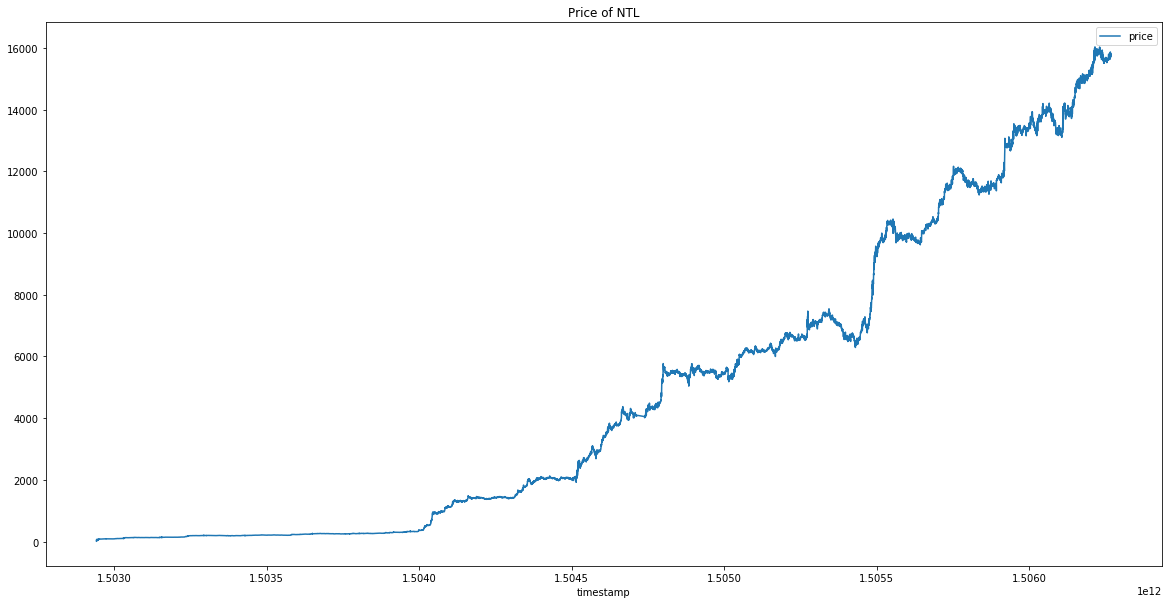

In [18]:
res.plot(y='price', x='timestamp', title="Price of NTL", figsize=(20, 10))

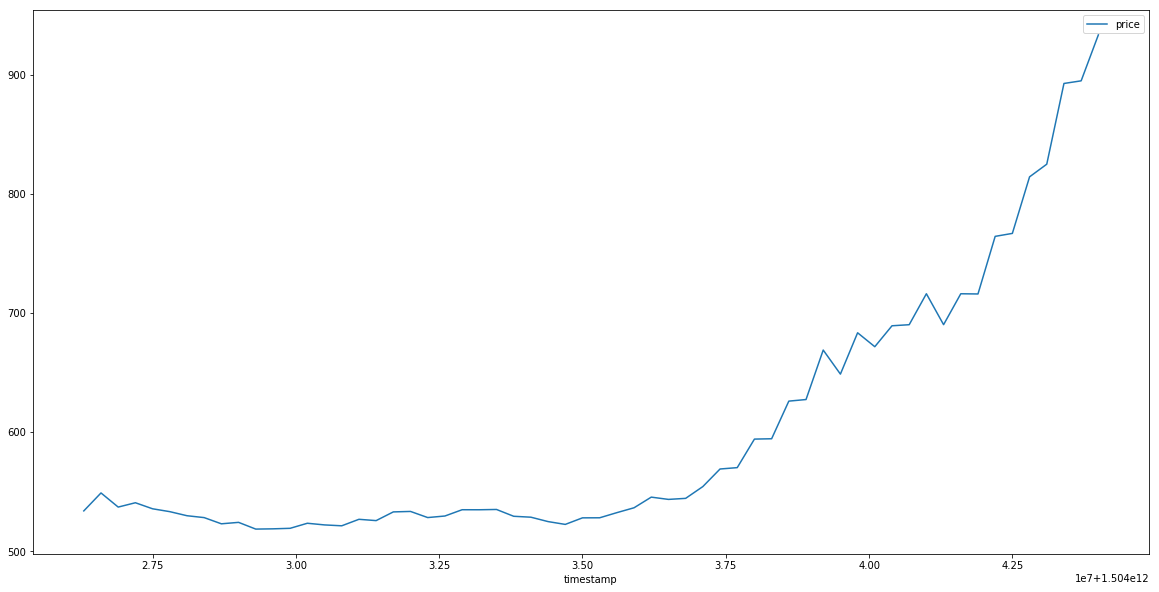

In [33]:
res[3620:3680].plot(y='price', x='timestamp', figsize=(20, 10))

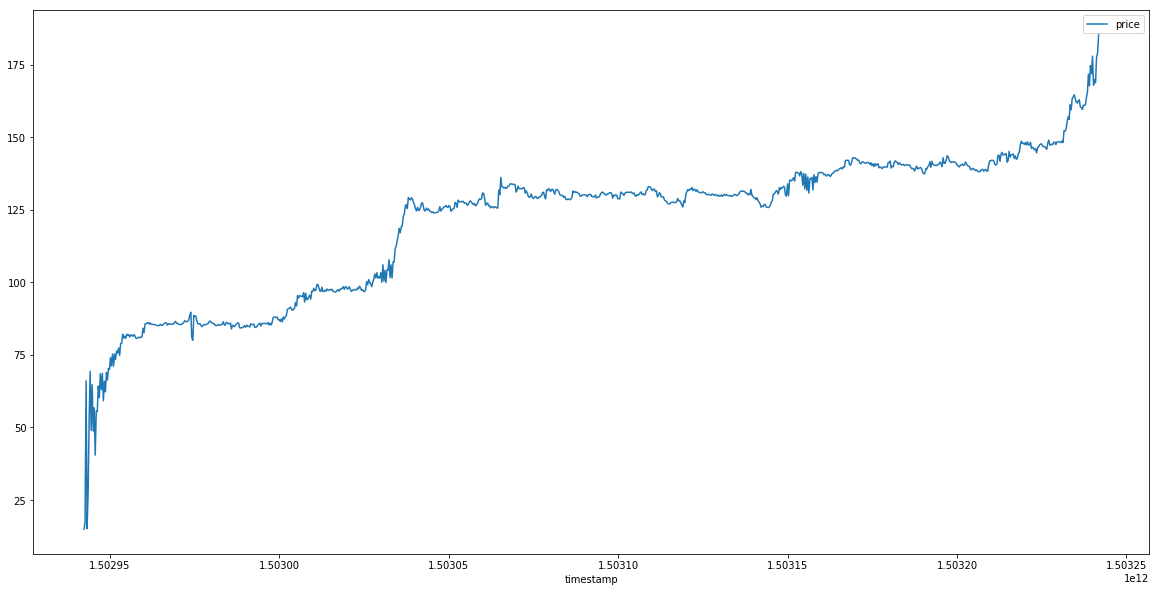

In [39]:
res[:1000].plot(y='price', x='timestamp', figsize=(20, 10))

In [35]:
res[3620:3680].price

3620    533.714256
3621    548.783655
3622    536.920070
3623    540.556677
3624    535.481545
3625    533.083098
3626    529.665124
3627    528.080914
3628    522.879665
3629    524.090066
3630    518.443375
3631    518.659013
3632    519.099587
3633    523.341051
3634    521.946695
3635    521.206717
3636    526.657347
3637    525.563236
3638    532.870926
3639    533.262455
3640    528.121125
3641    529.421972
3642    534.692148
3643    534.668960
3644    534.916479
3645    529.199267
3646    528.429898
3647    524.735892
3648    522.377386
3649    527.877664
3650    527.933111
3651    532.248432
3652    536.341201
3653    545.271366
3654    543.363220
3655    544.238517
3656    554.134252
3657    568.880787
3658    570.033641
3659    593.984993
3660    594.271079
3661    625.859775
3662    627.191760
3663    668.716749
3664    648.524036
3665    683.216455
3666    671.533788
3667    689.101586
3668    689.998877
3669    715.996107
3670    690.034756
3671    715.974480
3672    715.

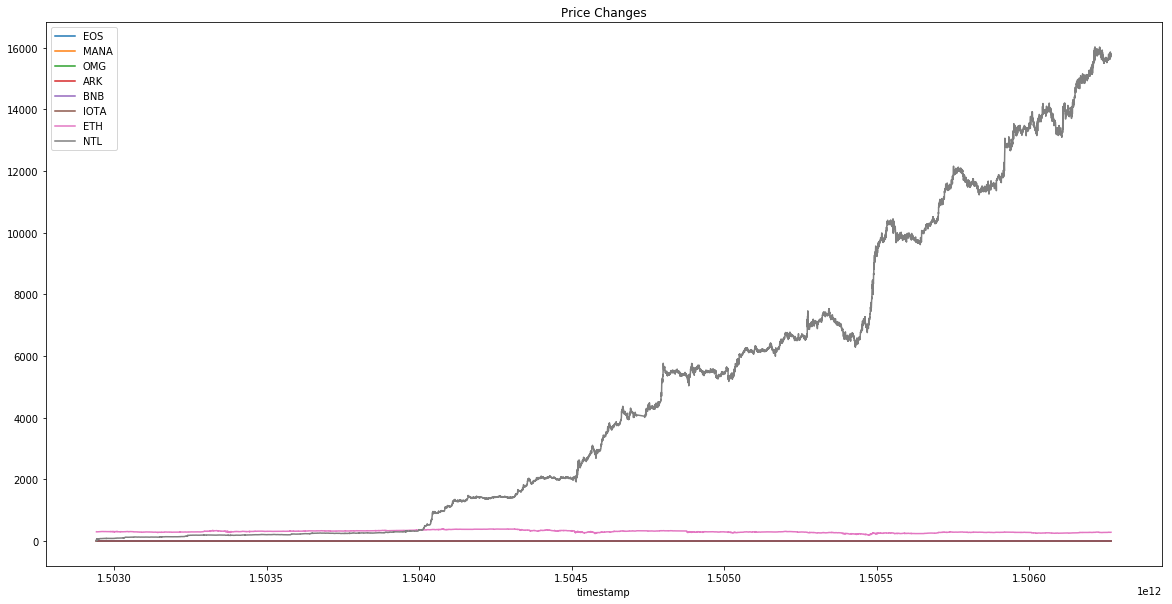

In [20]:
pd.merge(m,
         pd.DataFrame(dict(NTL=res['price'], timestamp=res['timestamp'])),
         on='timestamp').plot(x='timestamp', title="Price Changes", figsize=(20, 10))

count    11022.000000
mean      4788.827077
std       4827.561147
min         15.000000
25%        258.286592
50%       3022.614921
75%       7234.959250
max      16029.479287
Name: price, dtype: float64

In [22]:
m.describe()

,EOS,timestamp,MANA,OMG,ARK,BNB,IOTA,ETH
count,11022.000000,1.102200e+04,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000
mean,1.012053,1.504604e+12,0.065702,9.082596,3.162795,1.521508,0.459192,307.204804
std,0.334062,9.635453e+08,0.037275,1.075108,0.565987,0.709074,0.096970,37.771487
min,0.482895,1.502942e+12,0.013272,6.526780,1.481956,0.503544,0.301110,193.100000
25%,0.679737,1.503767e+12,0.017794,8.205073,2.866501,0.855845,0.408065,283.010000
50%,0.956240,1.504592e+12,0.078798,8.915736,3.124290,1.250860,0.448055,301.225000
75%,1.338159,1.505443e+12,0.097047,9.852690,3.413848,2.201847,0.497293,331.245000
max,1.583040,1.506267e+12,0.140380,13.793944,5.206336,2.956131,7.532500,394.320000
